## Standard Preparation Procedure
- Import libraries
- Check interesting tree's branches
- Prepare events with coffea

### Import necessary libraries

In [1506]:
from pathlib import Path
import numpy as np
import hist.dask as had
from matplotlib import pyplot as plt
import awkward as ak
import dask
import hist
from matplotlib.animation import FuncAnimation
from hist.dask import Hist
from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema, BaseSchema
from coffea.analysis_tools import PackedSelection
import mplhep as hep
import uproot
import coffea.nanoevents
from tqdm import tqdm_notebook
import pandas as pd

try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle
    
PHYSLITESchema.warn_missing_crossrefs = False

# Load style sheet
plt.style.use(hep.style.ATLAS) 
%matplotlib inline

In [ ]:
from importlib.metadata import version

for package in ["numpy", "awkward", "uproot", "coffea", "dask"]:
    print(f"# {package}: v{version(package)}")

# numpy: v1.26.4
# awkward: v2.6.5
# uproot: v5.3.9
# coffea: v2024.5.0
# dask: v2024.6.2


### Check Tree's info with uproot

In [83]:
# s3df file path
# file_path = "/fs/ddn/sdf/group/ldmx/users/dongyi/Higgs/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root"
# uchicago file path
file_path = "/data/dliu64/Higgs_analysis/evttree-mc23_13p6TeV.700855.Sh_2214_Zbb_ptZ_200_ECMS.deriv.DAOD_PHYS.e8514_e8528_s4162_r14622_p5855.root" # signal sample
#file_path = "/data/dliu64/Higgs_analysis/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root" # bkg sample

In [731]:
f = uproot.open(file_path)
# Check file's content
f.keys()

tree_path=f"{file_path}{':evttree'}"
tree = uproot.open(tree_path)
# Check tree's content
#tree.keys()

### Use NanoEventsFactory in coffea to import root file
$N_{cc}^{tag}=N_{cc}^{cc}+N_{bb}^{cc}+N_{qq}^{cc}$ $N_{tot}=N_{cc}^{true}+N_{bb}^{true}+N_{qq}^{true}$
$\epsilon_{cc}^{cc}=\frac{N_{cc}^{cc}}{N_{cc}^{true}}$ $\epsilon_{bb}^{cc}=\frac{N_{bb}^{cc}}{N_{bb}^{true}}$
$\epsilon_{qq}^{cc}=\frac{N_{qq}^{cc}}{N_{qq}^{true}}$ 

$$\frac{N_{cc}^{cc}}{N_{tot}}=\frac{N_{cc}^{tag}-\epsilon_{bb}^{cc}N_{bb}^{true}-\epsilon_{qq}^{cc}N_{qq}^{true}}{N_{tot}}$$

\begin{equation}
\sigma_{frac_{cc}}^2=\frac{N_{cc}^{cc}(N_{cc}^{cc}+N_{cc}^{tag})}{(N_{cc}^{tag})^3}
\end{equation}

$\sigma_{frac_{cc}}^2= $ <font color='red'>$\sigma_1^2$</font>$+$<font color='blue'>$\sigma_2^2$</font>$+$<font color='green'>$\sigma_3^2$</font>

<font color='red'>$\sigma_1^2=\frac{N_{cc}^{tag}(N_{cc}^{tag}+N_{tot})}{N_{tot}^3}$</font>

<font color='blue'>$\sigma_2^2=\frac{(\epsilon_{bb}^{cc})^2N_{bb}^{true}(N_{bb}^{true}+N_{tot})}{N_{tot}^3}$</font>
<font color='green'>$\sigma_3^2=\frac{(\epsilon_{qq}^{cc})^2N_{qq}^{true}(N_{qq}^{true}+N_{tot})}{N_{tot}^3}$</font>

In [1114]:
# s3df file path
# file_path = "/fs/ddn/sdf/group/ldmx/users/dongyi/Higgs/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root"
# uchicago file path
#file_path = "/data/dliu64/Higgs_analysis/evttree-mc23_13p6TeV.700855.Sh_2214_Zbb_ptZ_200_ECMS.deriv.DAOD_PHYS.e8514_e8528_s4162_r14622_p5855.root" # signal sample
file_path = "/data/dliu64/Higgs_analysis/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root" # bkg sample
global sample_type
sample_type = 'bkg'
global weighted_or_not
weighted_or_not = 'unweighted'

def D_GN2_Hcc(pHcc, pHbb, pTop, pQCD, fHbb=.3, fTop=.25):
    return np.log(pHcc/(fHbb*pHbb+fTop*pTop+(1-fHbb-fTop)*pQCD))

def D_GN2_Hbb(pHcc, pHbb, pTop, pQCD, fHcc=.02, fTop=.25):
    return np.log(pHbb/(fHcc*pHcc+fTop*pTop+(1-fHcc-fTop)*pQCD))

In [809]:
def filter_name(name):
    return name in [
        'HLT_j420_L1J100',
        'fatJetGN2XHbb', 'fatJetGN2XHcc',  
        'fatJetGN2Xv01Hbb', 'fatJetGN2Xv01Hcc', 
        'fatJetGN2Xv01QCD', 'fatJetGN2Xv01Top',
        'fatJetGN2XQCD', 'fatJetPt',
        'fatJetPx', 'fatJetPy',
        'fatJetPz', 'fatJetE',
        'fatJetM', 'fatJetNCHadrons', 
        'fatJetNBHadrons', 'vrJetIdFatJet', 
        'vrJetHadronGhostTruthLabelID', 'vrJetPt', 
        'vrJetM', 'eventMCWeight'
    ]

In [327]:
file_path=f"{file_path}{':evttree'}"
events = NanoEventsFactory.from_root(
    file_path,
    schemaclass=BaseSchema,
    uproot_options=dict(filter_name=filter_name),
    delayed=True,
).events()

In [737]:
pHcc = events['fatJetGN2Xv01Hcc'][0,0].compute()
pHbb = events['fatJetGN2Xv01Hbb'][0,0].compute()
ptop = events['fatJetGN2Xv01Top'][0,0].compute()
pqcd = events['fatJetGN2Xv01QCD'][0,0].compute()
pHcc, pHbb, ptop, pqcd

(0.01930837, 0.0032978004, 0.04016827, 0.9372255)

In [736]:
fHbb = 0.3
ftop = 0.25
np.log(pHcc/(pHbb*fHbb+ptop*ftop+(1-fHbb-ftop)*pqcd))

-3.109697537861495

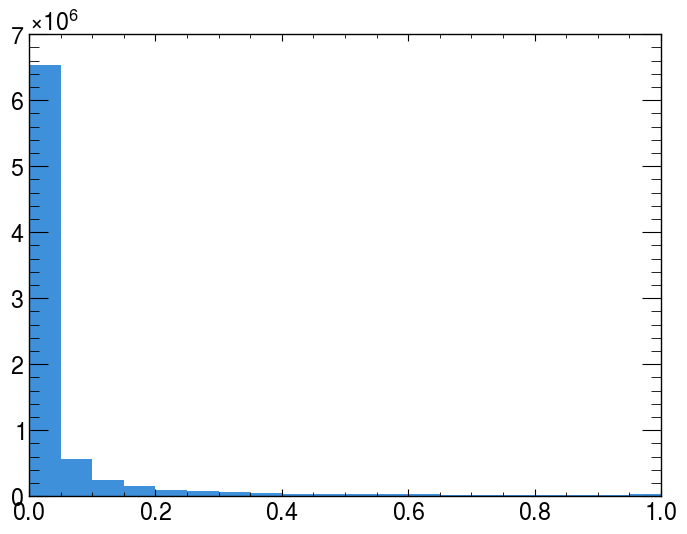

In [728]:
plt.hist(a, bins=20)
plt.show()

## Understand samples & Check basics kinematicsUnderstand samples & Check basics kinematics
Since different sample will have different kinematics. Some contain fatjet and some don't. Let's look at the mass and pT distribution without any cut first. Then based on that, we can develop the baseline cut (precut/pT&mass cut) 

#### Playground (scratch)

In [319]:
from dask.distributed import Client

client = Client("tls://172.16.44.167:8786")
client

Connection method: Direct,
Dashboard: /user/dongyi.liu@cern.ch/proxy/8787/status,
Comm: tls://172.16.44.167:8786,Workers: 0
Dashboard: /user/dongyi.liu@cern.ch/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [1165]:
%%time
m = events.fatJetM
mass = m[ak.num(m)>0].compute()
pt = events.fatJetPt
pt = pt[ak.num(m)>0].compute()
w = events.eventMCWeight
w = w[ak.num(m)>0].compute()

CPU times: user 413 ms, sys: 149 ms, total: 562 ms
Wall time: 39.2 s


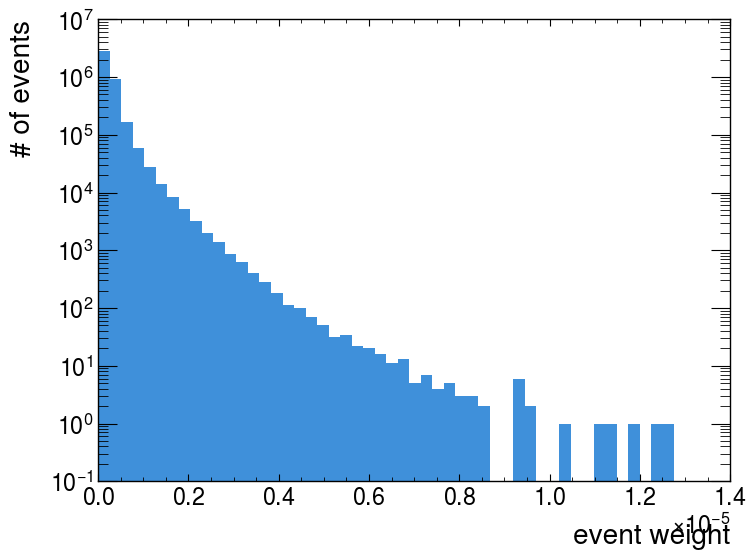

In [329]:
plt.hist(w, bins=50)
plt.xlabel('event weight')
plt.yscale('log')
plt.ylabel('# of events')
plt.show()


In [341]:
weighted_mass, weighted_mass_edges = np.histogram(mass[:,0], bins=50, weights=w)
unweighted_mass, unweighted_mass_edges = np.histogram(mass[:,0], bins=50)
weighted_pt, weighted_pt_edges = np.histogram(pt[:,0], bins=50, weights=w)
unweighted_pt, unweighted_pt_edges = np.histogram(pt[:,0], bins=50)

$N\pm\sqrt{N}$

Text(0, 1, '# of events')

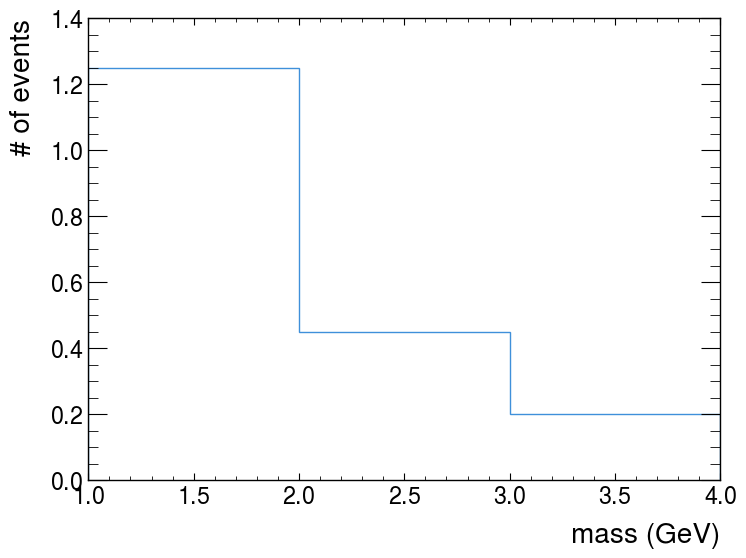

In [1072]:
x = np.arange(1, 5, 1)
N = np.array([25, 9, 4])
plt.stairs(N*.05,x)
plt.xlabel('mass (GeV)')
plt.ylabel('weighted # of events')

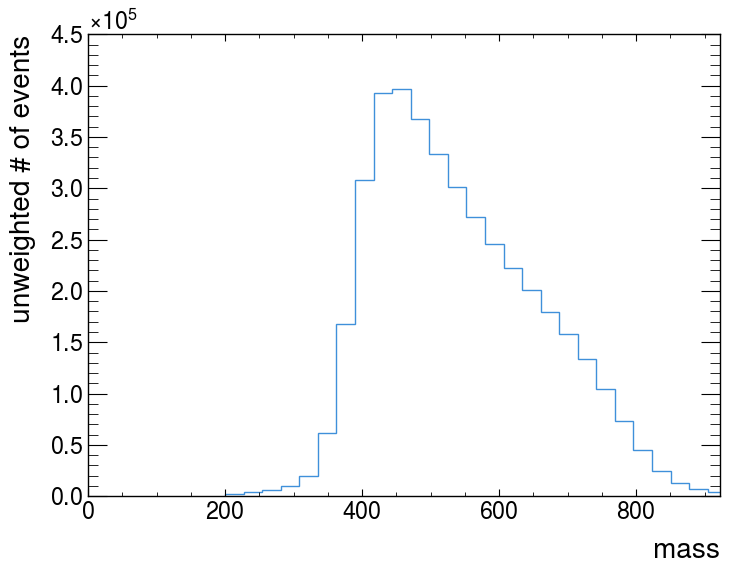

In [343]:
plt.stairs(unweighted_pt, unweighted_pt_edges)
plt.xlabel('mass')
plt.ylabel('unweighted # of events')
plt.xlim(min(unweighted_edges), max(unweighted_edges))
plt.show()

In [938]:
ak.sum(events.eventMCWeight.compute())

0.901857

In [308]:
#h = had.Hist.new.Regular(50, 50, 200, name='mass').Double()
h = Hist(hist.axis.Regular(10, -5, 5, name="x"), storage=hist.storage.Double())
h.fill([1.5, 2.5], weight=[0.5, 1.5])
#h.fill(mass=m[:, 0], weights=w) 


AttributeError: 'list' object has no attribute 'ndim'

In [333]:
weighted_hist

<Array [0.154, 0.193, 0.123, 0.0854, ..., 0, 0, 7.5e-07] type='50 * float64'>

In [344]:
dx = (unweighted_pt_edges[1:]-unweighted_pt_edges[:-1])[0]
sum(weighted_pt)*dx

24.269074630243505

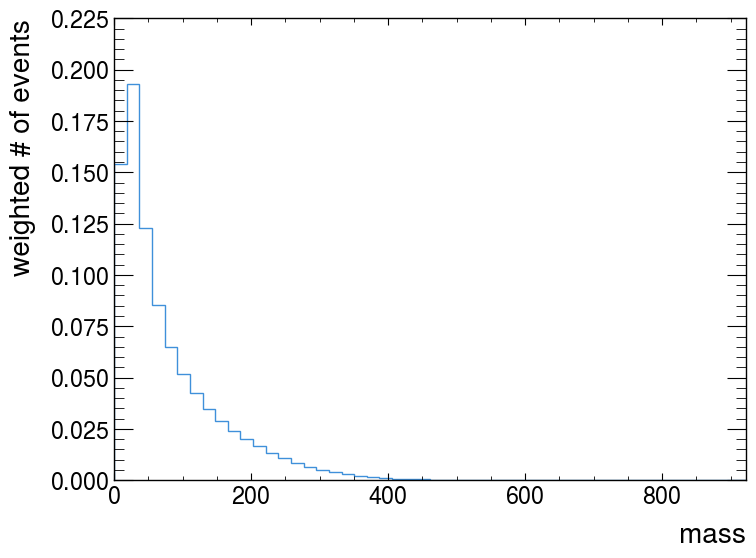

In [332]:
plt.stairs(weighted_hist, weighted_edges)
plt.xlabel('mass')
plt.ylabel('weighted # of events')
plt.xlim(min(weighted_edges), max(weighted_edges))
plt.show()

In [ ]:
a = events.fatJetM[(ak.num(events.fatJetM)==2)]
a[(a[:,0]>50)&(a[:,1]>40)].compute()

<Array [[89.2, 121], [...], ..., [96.5, 184]] type='89411 * [var * float32[...'>

In [ ]:
a = had.Hist.new.StrCat(fatjet_type, name='difatjet').Regular(50, 0, 1, name='HbbScore').Double()
print(a.axes[1].name)

HbbScore


### difatjet cut: only require to have 2 fatjets, without any pT and mass cuts

In [1166]:
%%time
### Takes too much time, how to optimize the running time???
difatjet_cut = ak.num(events.fatJetM)==2
fatjet_type = ['leading', 'subleading']

'''
     Question: why do subleading and leading fatjet give different number of events?
     Answer: because when we create a histogram with a certain range, we actully do cut on the corresponding kinematics.
             For example, the following 'fatJetM' histogram has the range from 50 to 200, which automatically means to have
             the cut of 50<mass<200GeV automatically.
'''

hist_list = {
'fatJetM': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(50, 50, 200, name='mass').Double(), ### When
'fatJetpT': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(50, 200, 1000, name='pT').Double(),
'fatJetGN2XHbb': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(50, 0, 1, name='HbbScore').Double(),
'fatJetGN2XHcc': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(50, 0, 1, name='HccScore').Double(),
'fatJetGN2XTop': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(50, 0, 1, name='TopScore').Double(),
'fatJetGN2XQCD': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(50, 0, 1, name='QCDScore').Double(),
'fatJetNBHadrons': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(7, 0, 6, name='NBHadrons').Double(),
'fatJetNCHadrons': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(7, 0, 6, name='NCHadrons').Double()
}

kinematics = {
    'fatJetM': events.fatJetM,
    'fatJetpT': events.fatJetPt,
    'fatJetGN2XHbb': events.fatJetGN2Xv01Hbb,
    'fatJetGN2XHcc': events.fatJetGN2Xv01Hcc,
    'fatJetGN2XTop': events.fatJetGN2Xv01Top,
    'fatJetGN2XQCD': events.fatJetGN2Xv01QCD,
    'fatJetNBHadrons': events.fatJetNBHadrons,
    'fatJetNCHadrons': events.fatJetNCHadrons
}

kinematics_difatjet = {}

count = 0
for i in range(len(fatjet_type)):
    for name, kinematic in hist_list.items():
        count += 1
        event = kinematics[name][difatjet_cut]
        kinematics_difatjet[name] = event # save event directly in the dictionary
        h = hist_list[name]
        fill_kwargs = {
            'difatjet': fatjet_type[i],
            h.axes[1].name: event[:, i]
        }
        # Fill the histogram
        h.fill(**fill_kwargs)
        #print(event[:,i].compute())
(hist_list, ) = dask.compute(hist_list)
(kinematics_distribution_difatjet,) = dask.compute(kinematics_difatjet)

CPU times: user 688 ms, sys: 339 ms, total: 1.03 s
Wall time: 22.7 s


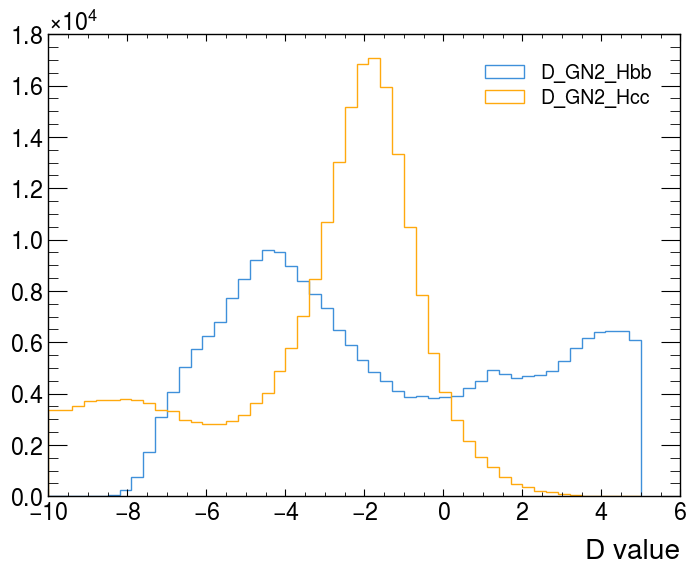

In [116]:
pHbb = kinematics_distribution_difatjet['fatJetGN2XHbb'][:,0]
pHcc = kinematics_distribution_difatjet['fatJetGN2XHcc'][:,0]
pTop = kinematics_distribution_difatjet['fatJetGN2XTop'][:,0]
pQCD = kinematics_distribution_difatjet['fatJetGN2XQCD'][:,0]
D_cc = D_GN2_Hcc(pHcc, pHbb, pTop, pQCD, fHbb=.3, fTop=.25)
D_bb = D_GN2_Hbb(pHcc, pHbb, pTop, pQCD, fHcc=.03, fTop=.25)
plt.hist(D_bb, bins=50, range=(-10,5), histtype='step', label='D_GN2_Hbb')
plt.hist(D_cc, bins=50, range=(-10,5), histtype='step', label='D_GN2_Hcc')
plt.xlabel('D value')
plt.legend()
plt.show()

#### Save kinematics distribution and histogram

In [155]:
def save_distribution(kinematics_distribution, cut, sample_type):
    for key, histograms in kinematics_distribution.items():
        # Combine the arrays to a DataFrame
        df = pd.DataFrame(histograms, columns=[f'leading_{key}', f'subleading_{key}'])
        df.to_csv(f'../../{sample_type}_kinematics_distribution/{key}_distribution_{cut}_{sample_type}.csv', index=False)

In [156]:
def save_histogram(hist_list, cut, sample_type):
    histogram_array = {}
    for name in hist_list.keys():
        histogram_array[name] = hist_list[name].to_numpy()[0]

    # Open a file in write mode.
    # Loop through the dictionary and save each to a CSV file
    for key, histograms in histogram_array.items():
        # Combine the arrays to a DataFrame
        df = pd.DataFrame(histograms.T, columns=[f'leading_{key}', f'subleading_{key}'])
        #df[f'{key}_edges'] = edges

        # Save to CSV
        df.to_csv(f'../../{sample_type}_kinematics_distribution/{key}_histogram_{cut}_{sample_type}.csv', index=False) #'''

In [121]:
save_distribution(kinematics_distribution_difatjet, 'difatjet', sample_type)
save_histogram(hist_list, 'difatjet', sample_type)

#### Make plots

In [190]:
def make_plot(name, hist_list, log):
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))
    hist_list[name].plot1d(ax=ax)
    print('Number of events',np.sum(hist_list[name].to_numpy()[0][0]))
    ax.legend()
    #ax.set_xlim(0,200)
    ax.set_ylabel('# of events')
    #plt.savefig('../slides_plots/Zbb_signal/HccScore_difatjet.pdf', dpi=200)
    if log == True:
        ax.set_yscale('log')

In [97]:
hist_list.keys()

dict_keys(['fatJetM', 'fatJetpT', 'fatJetGN2XHbb', 'fatJetGN2XHcc', 'fatJetGN2XTop', 'fatJetGN2XQCD', 'fatJetNBHadrons', 'fatJetNCHadrons'])

In [129]:
np.sum(hist_list['fatJetGN2XHbb'].to_numpy()[0][1])

79563.0

Number of events 79563.0


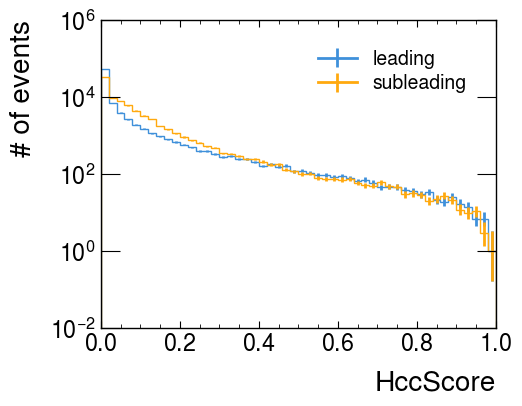

In [133]:
name = 'fatJetGN2XHcc'
make_plot(name, hist_list, True)

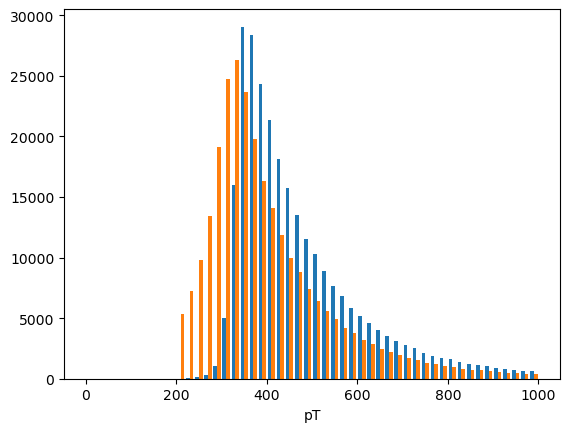

In [ ]:
a = events.fatJetPt[(ak.num(events.fatJetM)==2)]
b = a[a>20]
b = b[ak.num(b)!=0]

# leading and subleading di-fatjet pT without any pT cut
plt.hist(a.compute(), range=(0, 1000), bins=50)
# leading and subleading di-fatjet pT with pT cut of leading fatjetpT>450 and subleading fatjetpT>300
plt.hist(a[(a[:,0]>450)&(a[:,1]>300)].compute(), range=(0, 1000), bins=50) 
plt.xlabel('pT')
plt.show()

### difatjet + pT&m cut:

In [1167]:
%%time
difatjet_cut = ak.num(events.fatJetM)==2
fatjetm = kinematics_difatjet['fatJetM']
fatjetpt = kinematics_difatjet['fatJetpT']
pT_m_cut = (fatjetm[:,0]>50) & (fatjetpt[:,0]>450)

fatjet_type = ['leading', 'subleading']
histo_name = ['mass', 'pT', 'HbbScore', 'HccScore']

hist_list = {
'fatJetM': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(50, 0, 200, name='mass').Double(),
'fatJetpT': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(50, 200, 1000, name='pT').Double(),
'fatJetGN2XHbb': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(50, 0, 1, name='HbbScore').Double(),
'fatJetGN2XHcc': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(50, 0, 1, name='HccScore').Double(),
'fatJetGN2XTop': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(50, 0, 1, name='TopScore').Double(),
'fatJetGN2XQCD': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(50, 0, 1, name='QCDScore').Double(),
'fatJetNBHadrons': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(7, 0, 6, name='NBHadrons').Double(),
'fatJetNCHadrons': had.Hist.new.StrCat(fatjet_type, name='difatjet')
            .Regular(7, 0, 6, name='NCHadrons').Double()
}

kinematics_precut = {}

for i in range(len(fatjet_type)):
    for name, kinematic in kinematics_difatjet.items():
        event = kinematic[pT_m_cut]
        kinematics_precut[name] = event
        h = hist_list[name]
        fill_kwargs = {
            'difatjet': fatjet_type[i],
            h.axes[1].name: event[:, i]
        }
        # Fill the histogram
        h.fill(**fill_kwargs)
        #print(event[:,i].compute())
(hist_list, ) = dask.compute(hist_list)
(kinematics_distribution_precut,) = dask.compute(kinematics_precut)

CPU times: user 532 ms, sys: 194 ms, total: 726 ms
Wall time: 21.6 s


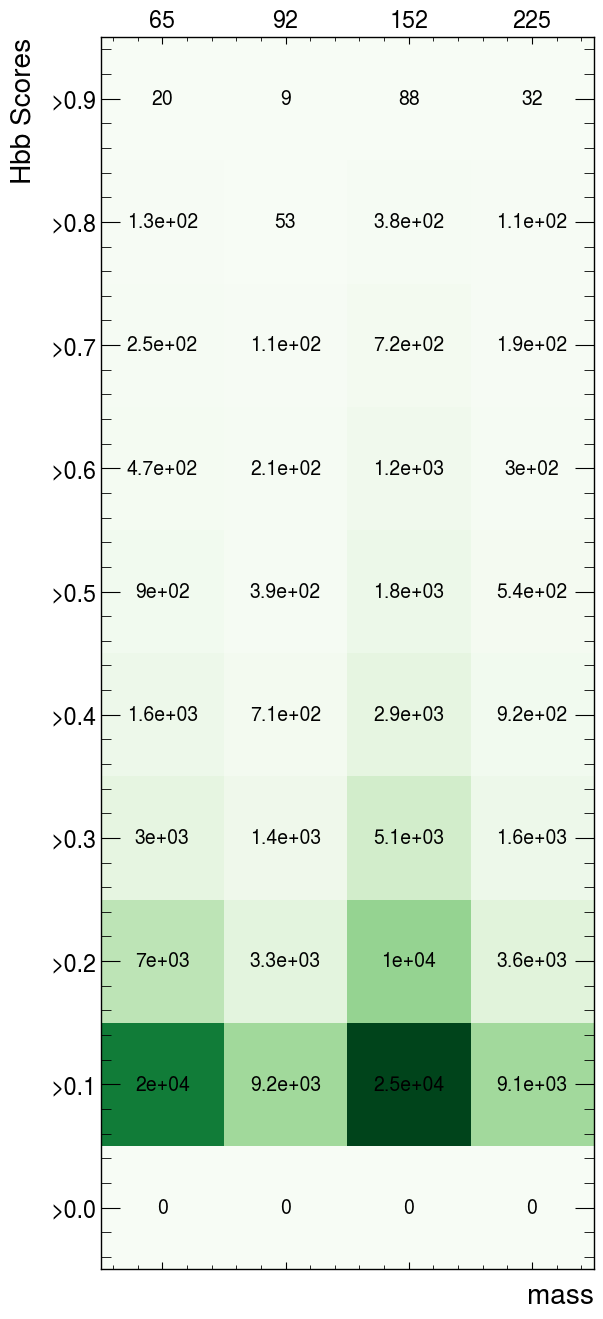

In [1446]:
Hbb_edges=np.linspace(0,1,11)
mass_edges=np.array([50, 80, 105, 200, 250])
precut, xedges, yedges = np.histogram2d(mass, Hbbscore, bins=[mass_edges, Hbb_edges])
precut = precut.T
xbins = (xedges[:-1]+xedges[1:])/2
fig, ax = plt.subplots(1,1,figsize=(8, 16))
ax.matshow(precut, origin='lower', cmap='Greens')
#ax.axis('off')


#X, Y = np.meshgrid(xedges, yedges)
#ax.pcolormesh(X, Y, H)
for (i, j), z in np.ndenumerate(H):
    #print(z)
    ax.text(j, i, '{:.2g}'.format(z), ha='center', va='center')
ax.set_xticks(np.linspace(0,len(xbins)-1,len(xbins)), labels=['%d'%i for i in xbins])
ax.set_yticks(np.linspace(0,len(yedges)-2,len(yedges)-1), labels=['>%.1f'%i for i in yedges[:-1]])
ax.set_xlabel('mass')
ax.set_ylabel('Hbb Scores')

plt.show()

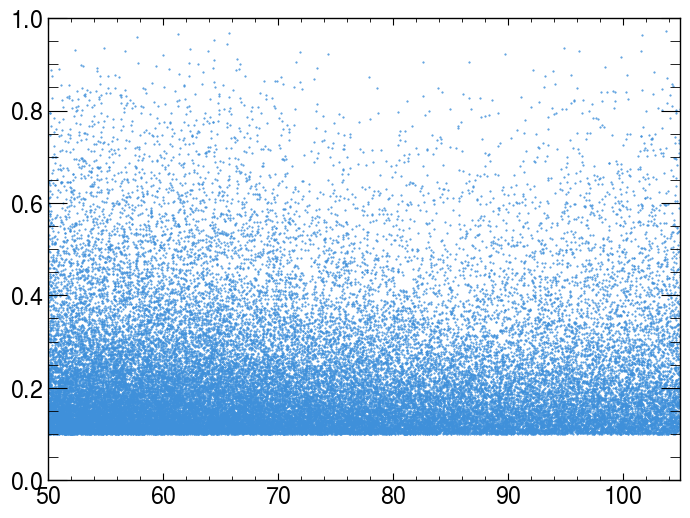

In [1445]:
mass_precut = np.array(kinematics_distribution_precut['fatJetM'][:,0])
Hbbscore_precut = np.array(kinematics_distribution_precut['fatJetGN2XHbb'][:,0])
plt.scatter(mass, Hbbscore, marker='.', s=1)
plt.ylim(0,1)
plt.xlim(50,105)
#plt.yscale('log')
plt.show()

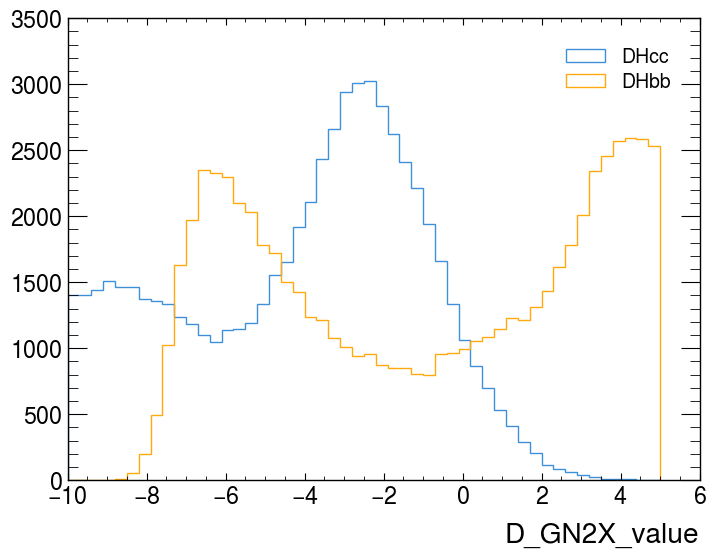

In [134]:
pHbb = kinematics_distribution_precut['fatJetGN2XHbb'][:,0]
pHcc = kinematics_distribution_precut['fatJetGN2XHcc'][:,0]
pTop = kinematics_distribution_precut['fatJetGN2XTop'][:,0]
pQCD = kinematics_distribution_precut['fatJetGN2XQCD'][:,0]
D_hcc = D_GN2_Hcc(pHcc, pHbb, pTop, pQCD, fHbb=.3, fTop=.25)
D_hbb = D_GN2_Hbb(pHcc, pHbb, pTop, pQCD, fHcc=.02, fTop=.25)
plt.hist(D_hcc, bins=50, range=(-10,5), histtype='step', label='DHcc')
plt.hist(D_hbb, bins=50, range=(-10,5), histtype='step', label='DHbb')
plt.legend()
plt.xlabel('D_GN2X_value')
plt.show()

#### Save kinematics distribution with precuts

In [135]:
print(kinematics_distribution_precut)
for key, histograms in kinematics_distribution_precut.items():
    # Combine the arrays to a DataFrame
    df = pd.DataFrame(histograms, columns=[f'leading_{key}', f'subleading_{key}'])
    df.to_csv(f'../../Zbb_kinematics_distribution/{key}_distribution_precut_Zbb.csv', index=False)

{'fatJetM': <Array [[89.2, 121], [...], ..., [96.5, 184]] type='79563 * [var * float32[...'>, 'fatJetpT': <Array [[599, 424], [...], ..., [461, 435]] type='79563 * [var * float32[pa...'>, 'fatJetGN2XHbb': <Array [[0.00267, 0.879], ..., [0.98, ...]] type='79563 * [var * float32[pa...'>, 'fatJetGN2XHcc': <Array [[0.0291, 0.000988], [...], ..., [...]] type='79563 * [var * float32...'>, 'fatJetGN2XTop': <Array [[0.671, 0.0974], ..., [0.000319, ...]] type='79563 * [var * float32...'>, 'fatJetGN2XQCD': <Array [[0.297, 0.0226], ..., [0.0196, ...]] type='79563 * [var * float32[p...'>, 'fatJetNBHadrons': <Array [[0, 2], [0, 0], ..., [0, ...], [2, 0]] type='79563 * [var * int32[p...'>, 'fatJetNCHadrons': <Array [[0, 3], [0, 0], ..., [0, ...], [3, 0]] type='79563 * [var * int32[p...'>}


In [136]:
histogram_array = {}
for name in hist_list.keys():
    histogram_array[name] = hist_list[name].to_numpy()[0]

# Open a file in write mode.
# Loop through the dictionary and save each to a CSV file
for key, histograms in histogram_array.items():
    # Combine the arrays to a DataFrame
    df = pd.DataFrame(histograms.T, columns=[f'leading_{key}', f'subleading_{key}'])
    #df[f'{key}_edges'] = edges
    
    # Save to CSV
    df.to_csv(f'../../Zbb_kinematics_distribution/{key}_histogram_precut_Zbb.csv', index=False) #'''

### Hbb/HccScore cuts

***Calculating D value***

D_GN2_Hcc is defined as
$$D_{Hcc}=ln(\frac{p_{Hcc}}{f_{Hbb}p_{Hbb}+f_{Top}p_{Top}+(1-f_{Hbb}-f_{Top})p_{QCD}})$$
[D_Hcc equation source](https://xbb-docs.docs.cern.ch/Xbb/GN2_track/#baseline-discriminant-for-xbb-tagging-for-initial-development-in-calibration)

#### Generate files

In [1423]:
def generate_data_with_Hbbcccut(kinematics_precut, bb_score, cc_score, strategy_number, sample_type):
    fatjetHbb = kinematics_precut['fatJetGN2XHbb']
    fatjetHcc = kinematics_precut['fatJetGN2XHcc']
    if strategy_number == 1:
        HbbHcc_cut = (fatjetHbb[:,0] > bb_score) & (fatjetHcc[:,0] > cc_score)
    if strategy_number == 2:
        HbbHcc_cut = (fatjetHbb[:,0] < bb_score) & (fatjetHcc[:,0] > cc_score)
    Nb = kinematics_precut['fatJetNBHadrons']
    Nc = kinematics_precut['fatJetNCHadrons']
    bb_tagging = (Nb[:,0] == 2)
    cc_tagging = (Nb[:,0] == 0) & (Nc[:,0] == 2)
    qq_tagging = (Nb[:,0] == 0) & (Nc[:,0] == 0)
    global sign
    sign = ['>', '<']
    

    difatjet_cut = ak.num(events.fatJetM)==2
    flavor_taggings = {'bb': bb_tagging, 'cc': cc_tagging, 'qq': qq_tagging}

    hist_list = {
    'fatJetM': had.Hist.new.StrCat(list(flavor_taggings), name='flavor_taggings')
                .Regular(50, 50, 200, name='mass').Double(),
    'fatJetpT': had.Hist.new.StrCat(list(flavor_taggings), name='flavor_taggings')
                .Regular(50, 450, 1000, name='pT').Double(),
    'fatJetGN2XHbb': had.Hist.new.StrCat(list(flavor_taggings), name='flavor_taggings')
                .Regular(50, 0, 1, name='HbbScore').Double(),
    'fatJetGN2XHcc': had.Hist.new.StrCat(list(flavor_taggings), name='flavor_taggings')
                .Regular(50, 0, 1, name='HccScore').Double(),
    'fatJetGN2XTop': had.Hist.new.StrCat(list(flavor_taggings), name='flavor_taggings')
                .Regular(50, 0, 1, name='TopScore').Double(),
    'fatJetGN2XQCD': had.Hist.new.StrCat(list(flavor_taggings), name='flavor_taggings')
                .Regular(50, 0, 1, name='QCDScore').Double(),
    }

    kinematics_bothcut = {}

    for flavor in flavor_taggings.keys():
        for name, kinematic in kinematics_precut.items():
            if name == 'fatJetNBHadrons' or name == 'fatJetNCHadrons':
                continue
            event = kinematic[HbbHcc_cut&flavor_taggings[flavor]]
            #event = kinematic[flavor_taggings[flavor]]
            event = event[ak.num(event)>0]
            #print(event[:,0].compute())
            kinematics_bothcut[flavor+'_'+name] = event
            h = hist_list[name]
            fill_kwargs = {
                'flavor_taggings': flavor,
                h.axes[1].name: event[:, 0]
            }
            # Fill the histogram
            h.fill(**fill_kwargs)
            #print(event[:,i].compute())
            
    hist_list['Hbb_Hcc_cut'] = f'HbbScore{sign[strategy_number-1]}%.2f_HccScore>%.2f'%(bb_score, cc_score)
    (hist_list, ) = dask.compute(hist_list)
    (kinematics_distribution_bothcut,) = dask.compute(kinematics_bothcut)
    '''
    try:
        import cPickle as pickle
    except ImportError:  # Python 3.x
        import pickle
    file_path = f'../../{sample_type}_{weighted_or_not}_kinematics_distribution/Hbb_Hcc_cuts/strategy_{strategy_number}/HbbScore{sign[strategy_number-1]}%.2f_HccScore>%.2f.p'%(bb_score, cc_score)
    with open(file_path, 'wb') as fp:
            pickle.dump(hist_list, fp, protocol=pickle.HIGHEST_PROTOCOL)
            '''
    return kinematics_distribution_bothcut, hist_list #'''

In [1443]:
np.sum(precut), np.sum(qq_bothcut+cc_bothcut+bb_bothcut)

(626426.0, 585078.0)

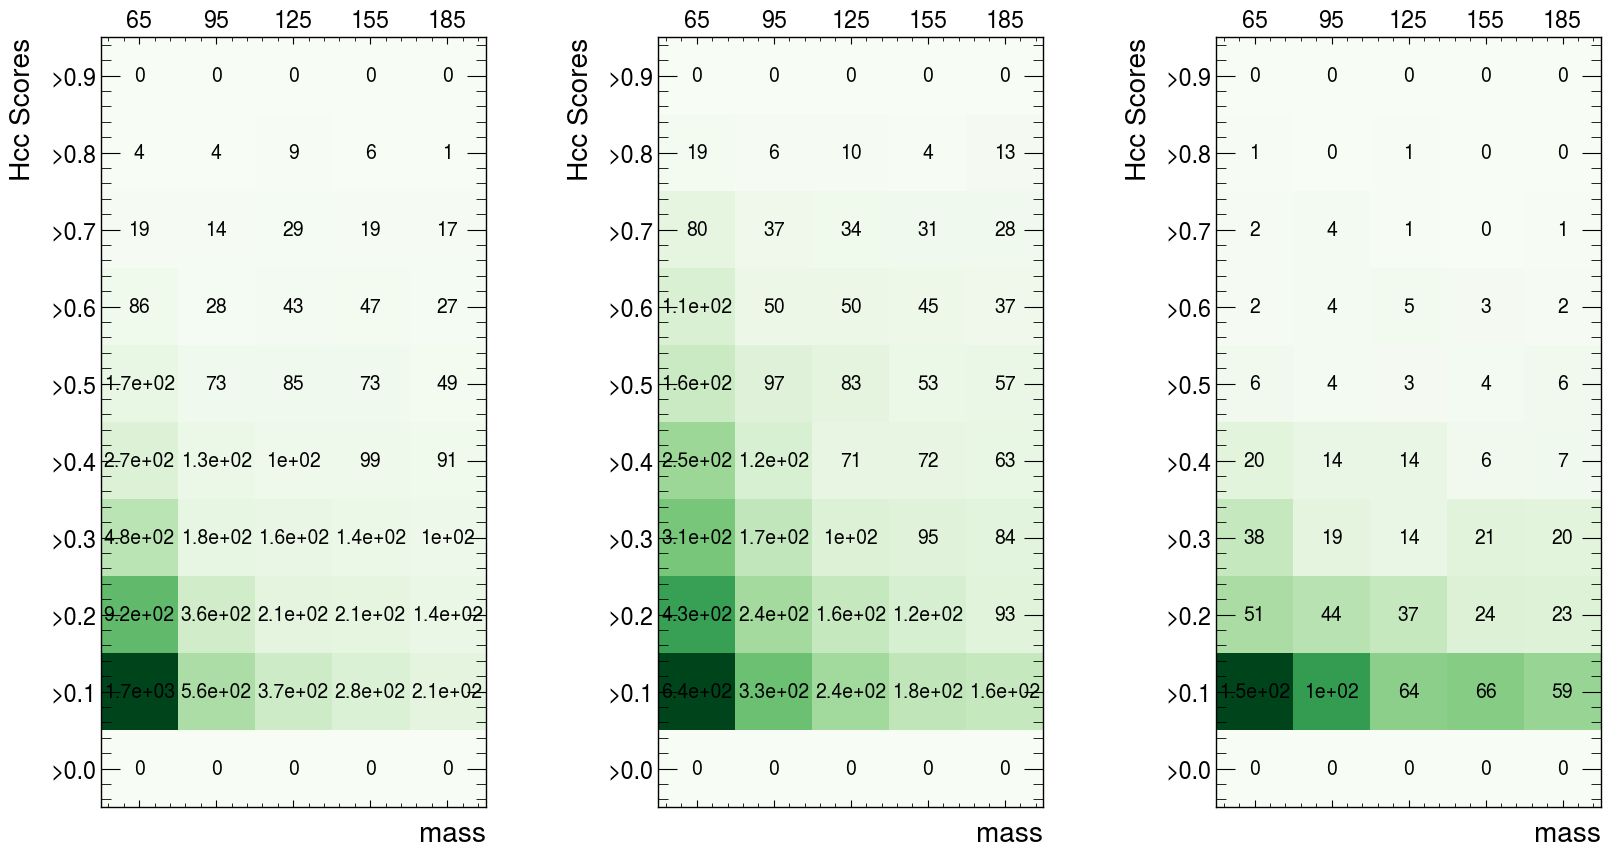

In [1502]:
Hbb_edges=np.linspace(0,1,11)
mass_edges=np.array([50, 80, 110, 140, 170, 200])
Hbb_precut, xedges, yedges = np.histogram2d(mass_precut, Hbbscore_precut, bins=[mass_edges, Hbb_edges])
Hcc_precut, xedges, yedges = np.histogram2d(mass_precut, Hccscore_precut, bins=[mass_edges, Hbb_edges])

qq_bothcut, xedges, yedges = np.histogram2d(qq_mass_bothcut, qq_Hccscore_bothcut, bins=[mass_edges, Hbb_edges])
cc_bothcut, xedges, yedges = np.histogram2d(cc_mass_bothcut, cc_Hccscore_bothcut, bins=[mass_edges, Hbb_edges])
bb_bothcut, xedges, yedges = np.histogram2d(bb_mass_bothcut, bb_Hccscore_bothcut, bins=[mass_edges, Hbb_edges])

Hbb_precut = Hbb_precut.T
Hcc_precut = Hcc_precut.T
qq_bothcut = qq_bothcut.T
cc_bothcut = cc_bothcut.T
bb_bothcut = bb_bothcut.T

#histogram = [Hbb_precut, Hcc_precut, qq_bothcut+cc_bothcut+bb_bothcut]
histogram = [qq_bothcut, cc_bothcut, bb_bothcut]


xbins = (xedges[:-1]+xedges[1:])/2
fig, axs = plt.subplots(1,len(histogram),figsize=(20, 10))
for k in range(len(histogram)):
    axs[k].matshow(histogram[k], origin='lower', cmap='Greens')

    for (i, j), z in np.ndenumerate(histogram[k]):
        axs[k].text(j, i, '{:.2g}'.format(z), ha='center', va='center')

    axs[k].set_xticks(np.linspace(0,len(xbins)-1,len(xbins)), labels=['%d'%i for i in xbins])
    axs[k].set_yticks(np.linspace(0,len(yedges)-2,len(yedges)-1), labels=['>%.1f'%i for i in yedges[:-1]])
    axs[k].set_xlabel('mass')
    axs[k].set_ylabel('Hcc Scores')

plt.show()

In [1526]:
np.sum(qq_bothcut, axis=0)

array([   0., 4819., 1501.,  605.,  317.,  154.,   78.,   30.,   10.,
          0.])

Text(0, 1, '# of events')

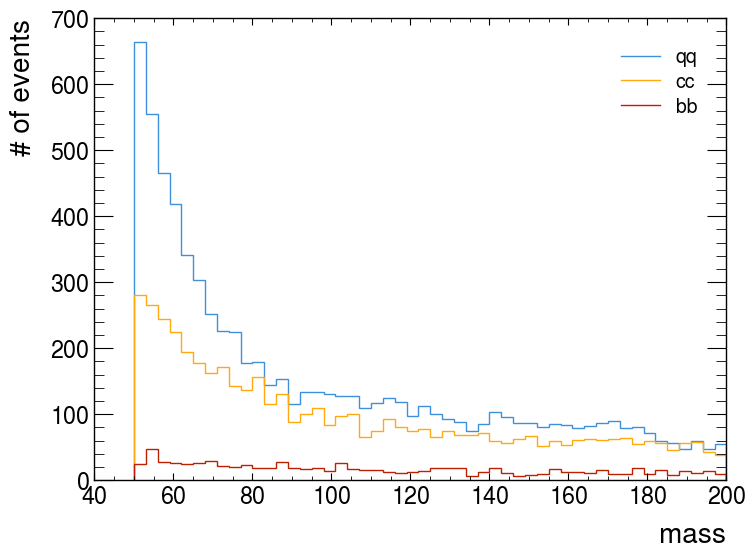

In [1524]:
'''mass_edges = np.array([ 50.,  53.,  56.,  59.,  62.,  65.,  68.,  71.,  74.,  77.,  80.,
        83.,  86.,  89.,  92.,  95.,  98., 101., 104., 107., 110., 113.,
       116., 119., 122., 125., 128., 131., 134., 137., 140., 143., 146.,
       149., 152., 155., 158., 161., 164., 167., 170., 173., 176., 179.,
       182., 185., 188., 191., 194., 197., 200.])#'''
qq_bothcut, xedges, yedges = np.histogram2d(qq_mass_bothcut, qq_Hbbscore_bothcut, bins=[mass_edges, Hbb_edges])
cc_bothcut, xedges, yedges = np.histogram2d(cc_mass_bothcut, cc_Hbbscore_bothcut, bins=[mass_edges, Hbb_edges])
bb_bothcut, xedges, yedges = np.histogram2d(bb_mass_bothcut, bb_Hbbscore_bothcut, bins=[mass_edges, Hbb_edges])
plt.stairs(np.sum(qq_bothcut, axis=-1), xedges, label='qq')
plt.stairs(np.sum(cc_bothcut, axis=-1), xedges, label='cc')
plt.stairs(np.sum(bb_bothcut, axis=-1), xedges, label='bb')
plt.legend()
plt.xlabel('mass')
plt.ylabel('# of events')
#plt.yscale('log')

In [1528]:
len(qq_mass_bothcut)

9338

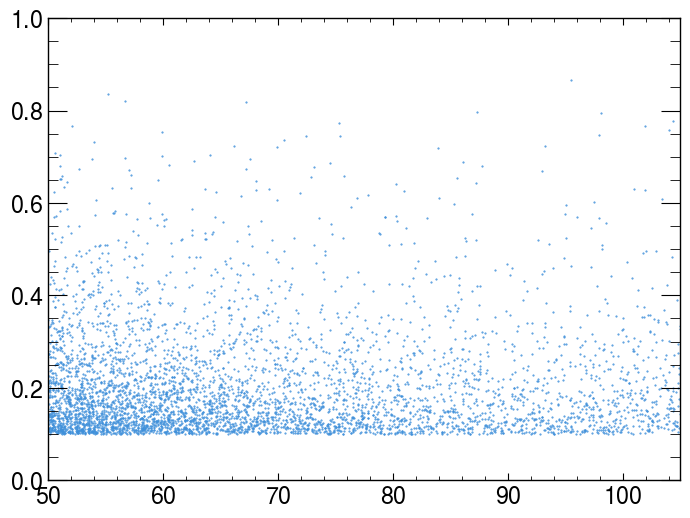

In [1494]:
qq_mass_bothcut = np.array(kinematics_distribution_bothcut['qq_fatJetM'][:,0])
qq_Hbbscore_bothcut = np.array(kinematics_distribution_bothcut['qq_fatJetGN2XHbb'][:,0])
qq_Hccscore_bothcut = np.array(kinematics_distribution_bothcut['qq_fatJetGN2XHcc'][:,0])
cc_mass_bothcut = np.array(kinematics_distribution_bothcut['cc_fatJetM'][:,0])
cc_Hbbscore_bothcut = np.array(kinematics_distribution_bothcut['cc_fatJetGN2XHbb'][:,0])
cc_Hccscore_bothcut = np.array(kinematics_distribution_bothcut['cc_fatJetGN2XHcc'][:,0])
bb_mass_bothcut = np.array(kinematics_distribution_bothcut['bb_fatJetM'][:,0])
bb_Hbbscore_bothcut = np.array(kinematics_distribution_bothcut['bb_fatJetGN2XHbb'][:,0])
bb_Hccscore_bothcut = np.array(kinematics_distribution_bothcut['bb_fatJetGN2XHcc'][:,0])

mass_precut = np.array(kinematics_distribution_precut['fatJetM'][:,0])
Hbbscore_precut = np.array(kinematics_distribution_precut['fatJetGN2XHbb'][:,0])
Hccscore_precut = np.array(kinematics_distribution_precut['fatJetGN2XHcc'][:,0])

plt.scatter(qq_mass_bothcut, qq_Hbbscore_bothcut, marker='.', s=1)
plt.ylim(0,1)
plt.xlim(50,105)
#plt.yscale('log')
plt.show()

In [1425]:
from dask.distributed import Client

client = Client("tls://172.16.44.167:8786")
client

Connection method: Direct,
Dashboard: /user/dongyi.liu@cern.ch/proxy/8787/status,
Comm: tls://172.16.44.167:8786,Workers: 0
Dashboard: /user/dongyi.liu@cern.ch/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [1492]:
%%time
strategy_number = 1
bb_score = 0.1
cc_score = .1
kinematics_distribution_bothcut, hist_list = generate_data_with_Hbbcccut(kinematics_precut, bb_score, cc_score, strategy_number, sample_type)

CPU times: user 1.12 s, sys: 259 ms, total: 1.38 s
Wall time: 27.3 s


In [1170]:
hist_list.keys()

dict_keys(['fatJetM', 'fatJetpT', 'fatJetGN2XHbb', 'fatJetGN2XHcc', 'fatJetGN2XTop', 'fatJetGN2XQCD', 'Hbb_Hcc_cut'])

In [1260]:
kinematics_distribution_bothcut.keys()

dict_keys(['bb_fatJetM', 'bb_fatJetpT', 'bb_fatJetGN2XHbb', 'bb_fatJetGN2XHcc', 'bb_fatJetGN2XTop', 'bb_fatJetGN2XQCD', 'cc_fatJetM', 'cc_fatJetpT', 'cc_fatJetGN2XHbb', 'cc_fatJetGN2XHcc', 'cc_fatJetGN2XTop', 'cc_fatJetGN2XQCD', 'qq_fatJetM', 'qq_fatJetpT', 'qq_fatJetGN2XHbb', 'qq_fatJetGN2XHcc', 'qq_fatJetGN2XTop', 'qq_fatJetGN2XQCD'])

Text(1, 0, 'D_GN2_bb')

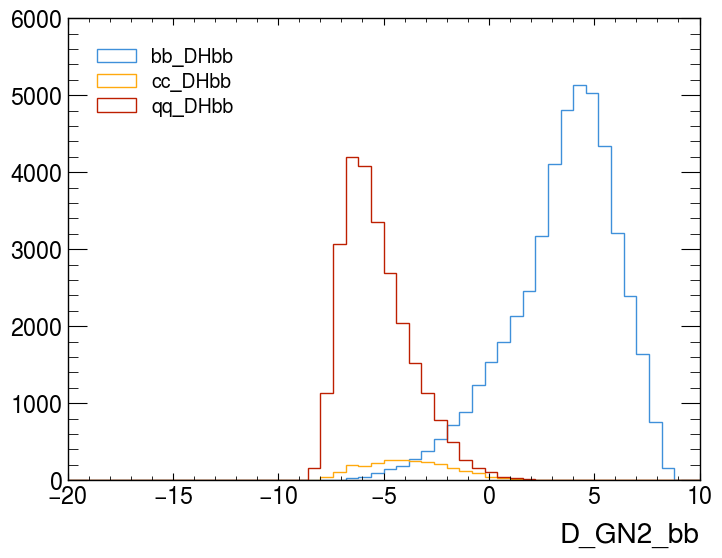

In [148]:
flavor_taggings = ['bb', 'cc', 'qq']

for flavor in flavor_taggings[:]:
    pHcc = kinematics_distribution_bothcut[f'{flavor}_fatJetGN2XHcc'][:,0]
    pHbb = kinematics_distribution_bothcut[f'{flavor}_fatJetGN2XHbb'][:,0]
    pTop = kinematics_distribution_bothcut[f'{flavor}_fatJetGN2XTop'][:,0]
    pQCD = kinematics_distribution_bothcut[f'{flavor}_fatJetGN2XQCD'][:,0]
    D_hcc = D_GN2_Hcc(pHcc, pHbb, pTop, pQCD, fHbb=.3, fTop=.25)
    D_hbb = D_GN2_Hbb(pHcc, pHbb, pTop, pQCD, fHcc=.02, fTop=.25)
    #plt.hist(D_hcc, bins=50, range=(-20,10), histtype='step', label=f'{flavor}_DHcc')
    plt.hist(D_hbb, bins=50, range=(-20,10), histtype='step', label=f'{flavor}_DHbb')
#plt.yscale('log')
plt.legend()
plt.xlabel('D_GN2_bb')

In [268]:
%%time
strategy_number=1
bb_score = 0.0
cc_score = 0.0
#kinematics_distribution_bothcut, hist_list = generate_data_with_Hbbcccut(kinematics_precut, bb_score, cc_score, strategy_number)
generate_data_with_Hbbcccut(kinematics_precut, bb_score, cc_score, strategy_number, sample_type)

KeyboardInterrupt: 

In [157]:
%%time
strategy_number=2
bb_scores = np.linspace(0,1,11)
cc_scores = np.linspace(0,1,11)
for bb_score in tqdm_notebook(bb_scores[:], total=len(bb_scores), desc="Processing records"):
    for cc_score in cc_scores:
        generate_data_with_Hbbcccut(kinematics_precut, bb_score, cc_score, strategy_number, sample_type)

<timed exec>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Processing records:   0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 23.2 s, sys: 399 ms, total: 23.6 s
Wall time: 2min 19s


In [350]:
strategy_number = 1
bb_score = 0.0
cc_score = 0.7
file_path = f'../../{sample_type}_{weight_or_not}_kinematics_distribution/Hbb_Hcc_cuts/strategy_{strategy_number}/HbbScore{sign[strategy_number-1]}%.2f_HccScore>%.2f.p'%(bb_score, cc_score)
with open(file_path, 'rb') as fp:
    data = pickle.load(fp)

In [ ]:
data.keys()

dict_keys(['fatJetM', 'fatJetpT', 'fatJetGN2XHbb', 'fatJetGN2XHcc', 'Hbb_Hcc_cut'])

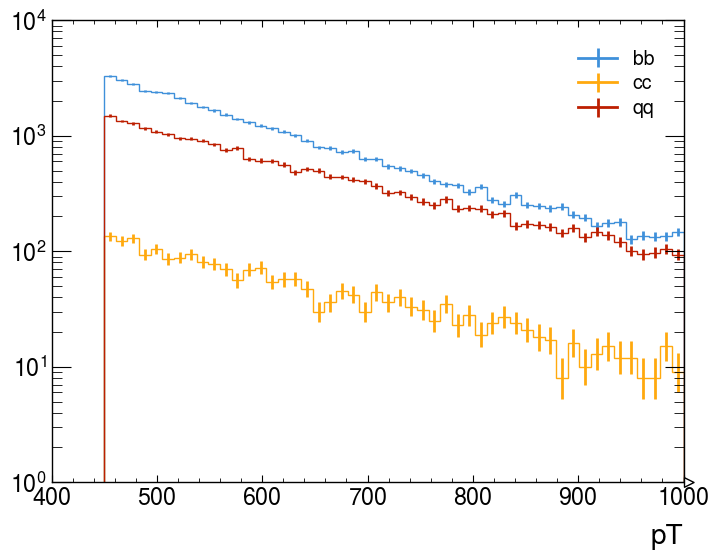

In [166]:
data['fatJetpT'].plot1d()
''' Verify that the uncertainties are given by sqrt(N)
edges = data['fatJetpT'].to_numpy()[2]
N = data['fatJetpT'].to_numpy()[0][1]
bins = (np.array([np.average(edges[i:i+2]) for i in range(len(edges)-1)]))
plt.errorbar(bins, N, yerr=np.sqrt(N)) #'''
plt.legend()
plt.yscale('log')


#### Make plots

In [ ]:
hist_list.keys()

dict_keys(['fatJetM', 'fatJetpT', 'fatJetGN2XHbb', 'fatJetGN2XHcc'])

In [ ]:
np.sum(hist_list[name].to_numpy()[0], axis=0)[12:]

array([29404., 55862., 51866., 48595., 45219., 42805., 40713., 38445.,
       36534., 35263., 33454., 31774., 30674., 29405., 28359., 27298.,
       26470., 25315., 24596., 23976., 22837., 21915., 21395., 20940.,
       19754., 19348., 18800., 18037., 17600., 16606., 16373., 15997.,
       15122., 14833., 14128., 13822., 13351., 12748.])

In [ ]:
data[name].to_numpy()

(array([[4.03630e+04, 2.52000e+03, 1.38600e+03, 8.73000e+02, 6.89000e+02,
         4.88000e+02, 3.64000e+02, 3.08000e+02, 2.47000e+02, 1.92000e+02,
         1.54000e+02, 1.64000e+02, 1.37000e+02, 1.00000e+02, 1.10000e+02,
         8.80000e+01, 6.70000e+01, 7.00000e+01, 5.70000e+01, 5.40000e+01,
         5.20000e+01, 4.00000e+01, 4.60000e+01, 2.70000e+01, 4.20000e+01,
         3.20000e+01, 2.20000e+01, 2.10000e+01, 2.30000e+01, 2.60000e+01,
         1.90000e+01, 1.20000e+01, 1.10000e+01, 1.40000e+01, 1.30000e+01,
         1.30000e+01, 1.20000e+01, 1.20000e+01, 1.50000e+01, 6.00000e+00,
         1.00000e+01, 7.00000e+00, 5.00000e+00, 6.00000e+00, 4.00000e+00,
         3.00000e+00, 0.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00],
        [2.35580e+04, 1.46820e+04, 1.01040e+04, 7.46800e+03, 5.91600e+03,
         4.86400e+03, 4.16700e+03, 3.59000e+03, 3.27100e+03, 2.88500e+03,
         2.55300e+03, 2.38000e+03, 2.06400e+03, 1.88200e+03, 1.78200e+03,
         1.67100e+03, 1.49000e+03, 1.

***Error propagation Validation***

For a given function $f(x, y)$, the way to evaluate its uncertainty
$$\sigma_{tot}^2=(\frac{\partial f}{\partial x}\sigma_x)^2+(\frac{\partial f}{\partial y}\sigma_y)^2$$
In our case, we are calculating the fraction $\frac{N_{bb}}{N_{tot}}$. Thus, the total error should be
$$\sigma_{frac}^2=(\frac{1}{N_{tot}}\sigma_{N_{bb}})^2+(\frac{N_{bb}}{N_{tot}^2}\sigma_{N_{tot}})^2$$
Since $\sigma_{N_{bb}}=\sqrt{N_{bb}}$, $\sigma_{N_{tot}}=\sqrt{N_{tot}}$, the Eq above should be
$$\sigma_{frac}^2=\frac{N_{bb}}{N_{tot}^3}(N_{tot}+N_{bb})$$

$\sigma_1^2=.04$

$\sigma_2^2=.07$

$\sigma_3^2=.33$

$\sigma_{tot}^2=.25$

In [1075]:
np.sqrt(Nbb*(Ntot-Nbb)/Ntot**3)
#np.sqrt(1/Nbb+1/Ntot)*(Nbb/Ntot)

array([0.096     , 0.16563466, 0.21650635])

(0.0, 1.0)

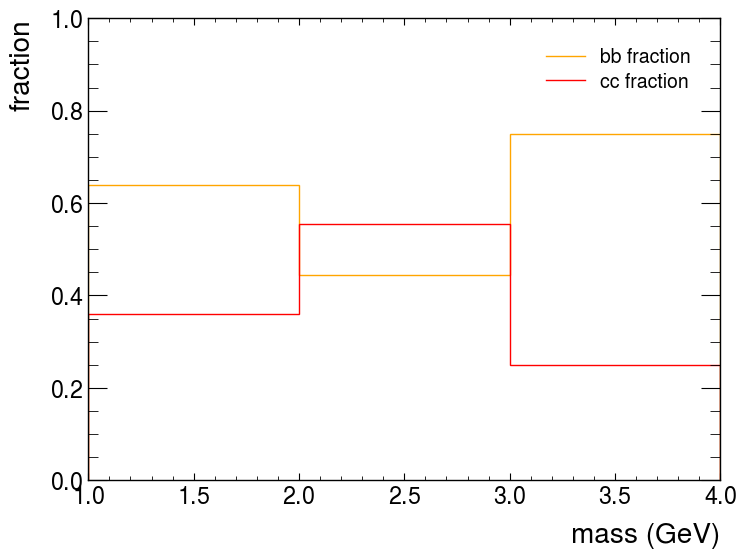

In [386]:
plt.stairs(Nbb/Ntot, m, color='orange', label='bb fraction')
plt.stairs(Ncc/Ntot, m, color='red', label='cc fraction')
plt.legend()
plt.xlabel('mass (GeV)')
plt.ylabel('fraction')
plt.ylim(0,1)

Text(0, 1, 'unweighted # of events')

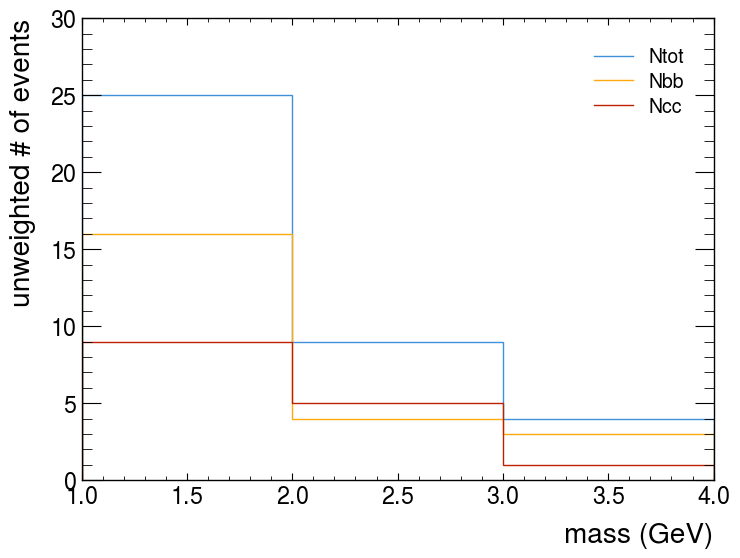

In [1074]:
m = np.arange(1, 5, 1)
Nbb=np.array([16, 4, 3])
Ncc=np.array([9, 5, 1])
Ntot = Nbb+Ncc
plt.stairs(Ntot, m, label='Ntot')
plt.stairs(Nbb, m, label='Nbb')
plt.stairs(Ncc, m, label='Ncc')
plt.legend()
plt.xlabel('mass (GeV)')
plt.ylabel('unweighted # of events')

In [372]:
Ntot = np.sum(N)
Nbb, Ncc, Nqq = np.sum(N, axis=-1)
Nbb*(Nbb+Ntot)/Ntot**3

7.039160323156944e-07

In [1190]:
strategy_number = 1
bb_score = 0.0
cc_score = 0.1
file_path = f'../../{sample_type}_{weight_or_not}_kinematics_distribution/Hbb_Hcc_cuts/strategy_{strategy_number}/HbbScore{sign[strategy_number-1]}%.2f_HccScore>%.2f.p'%(bb_score, cc_score)
with open(file_path, 'rb') as fp:
    data = pickle.load(fp)

In [1236]:
def make_flavor_fraction_plot(name, data, hist_name):
    Ntot_before_cut, Ncc_before_cut, Nbb_before_cut, Nqq_before_cut = initialize_N(strategy_number, sample_type, weight_or_not)
    # Make fraction plots
    flavor_taggings = ['bb', 'cc', 'qq']

    Ntot =  np.sum(data[name].to_numpy()[0]) # Ntot after cut
    Ntot_bin_after_cut = np.sum(data[name].to_numpy()[0], axis=0)
    N_bins = len(Ntot_bin_after_cut)
    edges = data[name].to_numpy()[2]
    bins = (np.array([np.average(edges[i:i+2]) for i in range(len(edges)-1)]))
    N_flavor = data[name].to_numpy()[0]
    sigma2_frac = N_flavor/Ntot**3*(Ntot+N_flavor)
    sigma2_frac = N_flavor/(Ntot_bin_after_cut)**3*(np.tile(Ntot_bin_after_cut, (len(N_flavor), 1))+N_flavor)

    fig, ax = plt.subplots(1, 1, figsize = (5, 4))
    for flavor, i in zip(flavor_taggings, range(len(flavor_taggings))):
        #print(f'fraction of {flavor} events for {name}=%.2f+-%.3f%%'%(np.sum(N_flavor, axis=-1)[i]/Ntot*100, np.sqrt(np.sum(sigma2_frac, axis=-1)/N_bins**2)[i]*100))
        print(f'fraction of {flavor} events for {name}=%.2f+-%.3f%%'\
              %(np.sum(N_flavor, axis=-1)[i]/Ntot*100, 0)) 
                #np.sqrt(Ntot_after_cut+bb_efficiency**2*Nbb_before_cut+qq_efficiency**2*Nqq_before_cut)/Ntot_before_cut*100)) #'''
        ax.stairs(np.divide(N_flavor[i], np.sum(N_flavor, axis=0)), edges, label=flavor)
        #ax.errorbar(bins, np.divide(N_flavor[i], np.sum(N_flavor, axis=0)), yerr=sigma_frac[i], linestyle='')
    print(f'total number of events for {name}', Ntot, '\n')
    
    ax.legend()
    ax.set_xlabel(hist_name)
    ax.set_ylabel('fraction')
    ax.set_ylim(0,1) #'''

fraction of bb events for fatJetM=6.96+-0.000%
fraction of cc events for fatJetM=38.60+-0.000%
fraction of qq events for fatJetM=54.44+-0.000%
total number of events for fatJetM 21159.0 

fraction of bb events for fatJetpT=7.50+-0.000%
fraction of cc events for fatJetpT=40.24+-0.000%
fraction of qq events for fatJetpT=52.26+-0.000%
total number of events for fatJetpT 26176.0 

fraction of bb events for fatJetGN2XHbb=7.50+-0.000%
fraction of cc events for fatJetGN2XHbb=40.26+-0.000%
fraction of qq events for fatJetGN2XHbb=52.24+-0.000%
total number of events for fatJetGN2XHbb 26196.0 

fraction of bb events for fatJetGN2XHcc=7.50+-0.000%
fraction of cc events for fatJetGN2XHcc=40.26+-0.000%
fraction of qq events for fatJetGN2XHcc=52.24+-0.000%
total number of events for fatJetGN2XHcc 26196.0 



/tmp/ipykernel_203/1382700438.py:13: RuntimeWarning: invalid value encountered in divide
  sigma2_frac = N_flavor/(Ntot_bin_after_cut)**3*(np.tile(Ntot_bin_after_cut, (len(N_flavor), 1))+N_flavor)
/tmp/ipykernel_203/1382700438.py:21: RuntimeWarning: invalid value encountered in divide
  ax.stairs(np.divide(N_flavor[i], np.sum(N_flavor, axis=0)), edges, label=flavor)


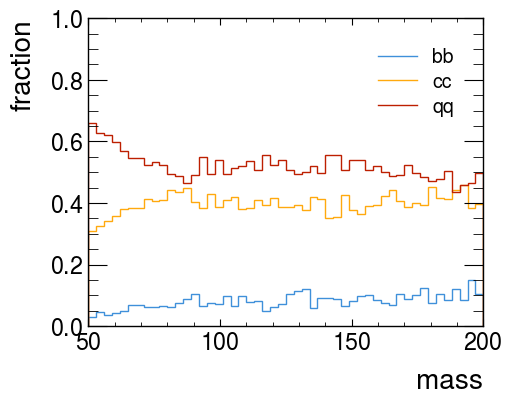

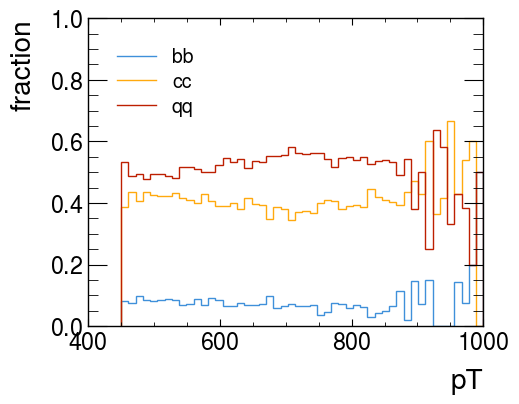

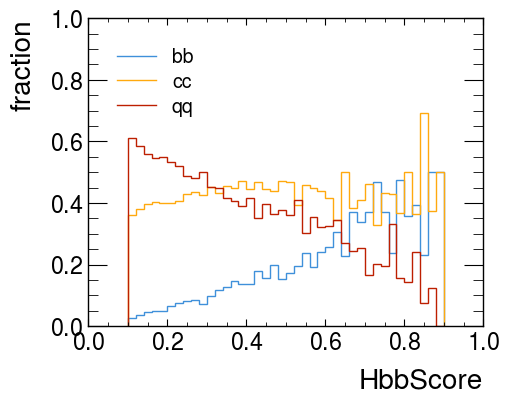

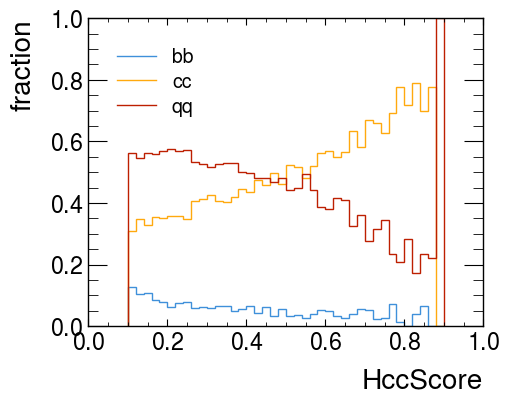

In [1237]:
hist_names = ['mass', 'pT', 'HbbScore', 'HccScore']
for name, hist_name in zip(data.keys(), hist_names):
    if name == 'Hbb_Hcc_cut':
        continue
    make_flavor_fraction_plot(name, data, hist_name)

In [1139]:
def make_flavor_number_plots(name, hist_list, log):
    
    Ntot = np.sum(data[name].to_numpy()[0])
    N_flavor = np.sum(hist_list[name].to_numpy()[0], axis=-1)
    
    flavor_taggings = ['bb', 'cc', 'qq']
    for flavor, i in zip(flavor_taggings, range(len(flavor_taggings))):
        print(f'Number of {flavor} events for {name} %i+-%i'%(N_flavor[i], np.sqrt(N_flavor[i])))
        print(f'fraction uncertainty of {flavor} for {name} should be %.2f+-%.3f%%'%(N_flavor[i]/Ntot*100, ((N_flavor[i]+np.sqrt(N_flavor[i]))/Ntot-(N_flavor[i]-np.sqrt(N_flavor[i]))/Ntot)*100))
    print(f'Number of total events for {name} %i+-%i\n'%(Ntot, np.sqrt(Ntot)))
    
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))
    hist_list[name].plot1d(ax=ax)
    ax.stairs(np.sum(hist_list[name].to_numpy()[0], axis=0), hist_list[name].to_numpy()[2], label='tot')
    ax.legend()
    ax.set_ylabel('# of events')
    #plt.savefig('../slides_plots/Zbb_signal/HccScore_difatjet.pdf', dpi=200)
    if log==True:
        ax.set_yscale('log') #'''
    


In [1187]:
%%time
strategy_number = 1
bb_score = 0.
cc_score = .1
kinematics_distribution_bothcut, hist_list = generate_data_with_Hbbcccut(kinematics_precut, bb_score, cc_score, strategy_number, sample_type)

CPU times: user 827 ms, sys: 316 ms, total: 1.14 s
Wall time: 15 s


In [1227]:
strategy_number = 1
bb_score = 0.1
cc_score = 0.1
file_path = f'../../{sample_type}_{weight_or_not}_kinematics_distribution/Hbb_Hcc_cuts/strategy_{strategy_number}/HbbScore{sign[strategy_number-1]}%.2f_HccScore>%.2f.p'%(bb_score, cc_score)
with open(file_path, 'rb') as fp:
    data = pickle.load(fp)

Number of bb events for fatJetM 1473+-38
fraction uncertainty of bb for fatJetM should be 6.96+-0.363%
Number of cc events for fatJetM 8168+-90
fraction uncertainty of cc for fatJetM should be 38.60+-0.854%
Number of qq events for fatJetM 11518+-107
fraction uncertainty of qq for fatJetM should be 54.44+-1.014%
Number of total events for fatJetM 21159+-145

Number of bb events for fatJetpT 1962+-44
fraction uncertainty of bb for fatJetpT should be 7.50+-0.338%
Number of cc events for fatJetpT 10534+-102
fraction uncertainty of cc for fatJetpT should be 40.24+-0.784%
Number of qq events for fatJetpT 13680+-116
fraction uncertainty of qq for fatJetpT should be 52.26+-0.894%
Number of total events for fatJetpT 26176+-161

Number of bb events for fatJetGN2XHbb 1964+-44
fraction uncertainty of bb for fatJetGN2XHbb should be 7.50+-0.338%
Number of cc events for fatJetGN2XHbb 10547+-102
fraction uncertainty of cc for fatJetGN2XHbb should be 40.26+-0.784%
Number of qq events for fatJetGN2XHbb 

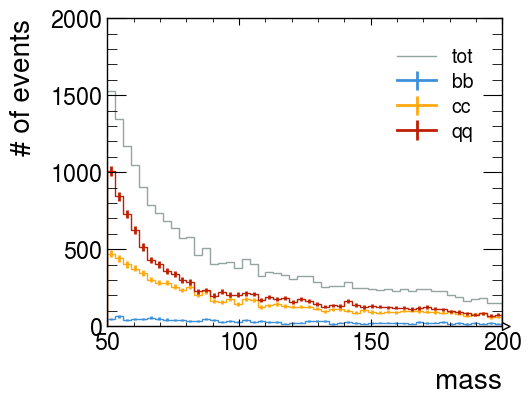

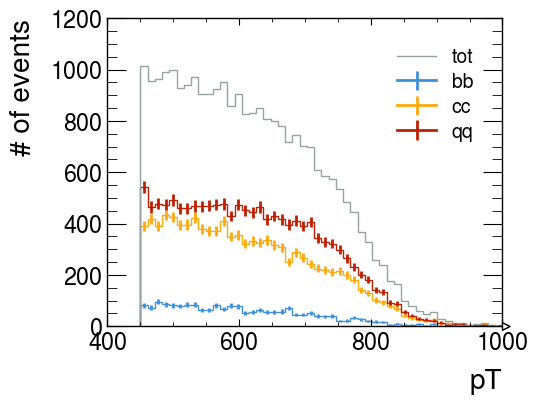

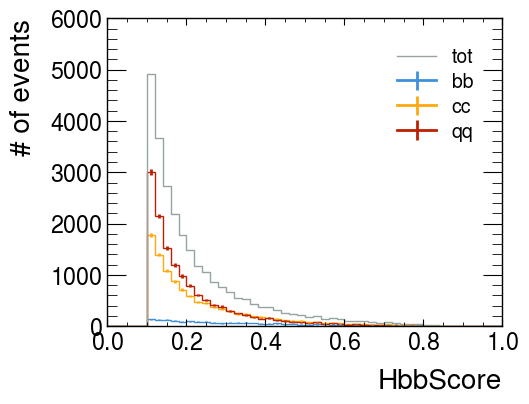

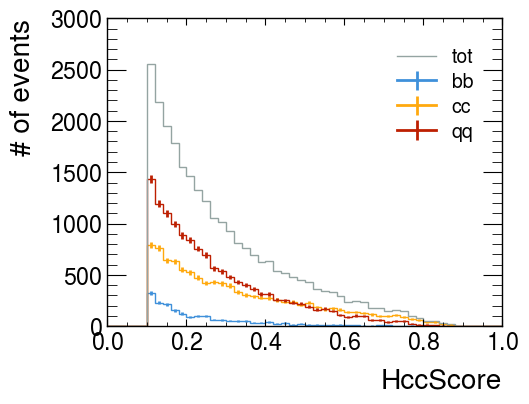

In [1228]:
for name in data.keys():
    if name == 'Hbb_Hcc_cut':
        continue
    make_flavor_number_plots(name, data, False)
    #make_flavor_number_plots(name, hist_list, False)

## Generate events with additional cuts (HbbScores & HccScores) to optimize Hbb/cc cuts

### Accelerate programming with dask & Generating data (Hbb/Hcc Scores with different cuts)
Make histograms of GN2XHbbScore and GN2XHccScore with two single cuts (HbbScore>a, HccScore>b), and one double cut (HbbScore>a & HccScore>b) separtely. In each histogram, there are a bb/cc/qq tagging folder inside it, which means each histogram has the form ([Array1],[Array2],[Array3]), indecating (bb, cc, qq)

In [1163]:
from dask.distributed import Client

client = Client("tls://172.16.44.167:8786")
client

Connection method: Direct,
Dashboard: /user/dongyi.liu@cern.ch/proxy/8787/status,
Comm: tls://172.16.44.167:8786,Workers: 0
Dashboard: /user/dongyi.liu@cern.ch/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Cut Choice 2: HbbScore<a & HccScore>b

In [ ]:
import coffea.processor as processor

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events, N_bins, bb_score, cc_score):
        cut_pt_m = (events.fatJetPt > 450) & ((events.fatJetM > 105) & (events.fatJetM < 210)) | ((events.fatJetM > 50) & (events.fatJetM < 80)) 
        di_fatjet = ak.num(events.fatJetPt) == 2
        
        bb_tagging = cut_pt_m & (events.fatJetNBHadrons == 2) & (events.fatJetNCHadrons > -1)
        cc_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 2)
        qq_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 0)
        
        cuts = {'bb': bb_tagging, 'cc': cc_tagging, 'qq': qq_tagging}

        h_GN2XHbbScore_Hbbcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hbbscore').Double())
        h_GN2XHccScore_Hbbcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hccscore').Double())
        h_GN2XHbbScore_Hcccut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hbbscore').Double())
        h_GN2XHccScore_Hcccut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hccscore').Double())
        h_GN2XHbbScore_bothcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hbbscore').Double())
        h_GN2XHccScore_bothcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hccscore').Double())
        h_pT_bothcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 200, 1000, name='pT').Double())
        h_mass_bothcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 50, 200, name='mass').Double())
        
        HbbScorecuts = events.fatJetGN2Xv01Hbb < bb_score
        HccScorecuts = events.fatJetGN2Xv01Hcc > cc_score

        for name, cut in cuts.items():
            h_GN2XHbbScore_Hbbcut.fill(cut=name, Hbbscore=ak.flatten(events.fatJetGN2Xv01Hbb[di_fatjet & cut & HbbScorecuts]))
            h_GN2XHbbScore_Hcccut.fill(cut=name, Hbbscore=ak.flatten(events.fatJetGN2Xv01Hbb[di_fatjet & cut & HccScorecuts]))
            h_GN2XHbbScore_bothcut.fill(cut=name, Hbbscore=ak.flatten(events.fatJetGN2Xv01Hbb[di_fatjet & cut & HccScorecuts & HbbScorecuts]))
            h_GN2XHccScore_Hbbcut.fill(cut=name, Hccscore=ak.flatten(events.fatJetGN2Xv01Hcc[di_fatjet & cut & HbbScorecuts]))
            h_GN2XHccScore_Hcccut.fill(cut=name, Hccscore=ak.flatten(events.fatJetGN2Xv01Hcc[di_fatjet & cut & HccScorecuts]))
            h_GN2XHccScore_bothcut.fill(cut=name, Hccscore=ak.flatten(events.fatJetGN2Xv01Hcc[di_fatjet & cut & HccScorecuts & HbbScorecuts]))
            h_pT_bothcut.fill(cut=name, pT=ak.flatten(events.fatJetPt[di_fatjet & cut & HccScorecuts & HbbScorecuts]))
            h_mass_bothcut.fill(cut=name, mass=ak.flatten(events.fatJetM[di_fatjet & cut & HccScorecuts & HbbScorecuts]))


        return {
            "entries": ak.num(events, axis=0),
            "GN2XHbbScore_Hbbcut": h_GN2XHbbScore_Hbbcut,
            "GN2XHccScore_Hbbcut": h_GN2XHccScore_Hbbcut,
            "GN2XHbbScore_Hcccut": h_GN2XHbbScore_Hcccut,
            "GN2XHccScore_Hcccut": h_GN2XHccScore_Hcccut,
            "GN2XHbbScore_bothcut": h_GN2XHbbScore_bothcut,
            "GN2XHccScore_bothcut": h_GN2XHccScore_bothcut,
            "pT": h_pT_bothcut,
            "mass": h_mass_bothcut,
            "cuts": 'HbbScorecuts<%.2f, HccScorecuts>%.2f'%(bb_score, cc_score),
        }

    def postprocess(self, accumulator):
        pass

#### Irregular bb scores and cc scores choice VS regular bb and cc scores choice
- bb_scores = np.array([0. , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.14, 0.18, 0.24, 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1. ])
- cc_scores = np.array([0., .01, .02, .03, .04, .06, .08, .1, .2, .3, .5, .7, .9])

#### reggular bb and cc scores choice
- bb_scores = cc_scores = np.array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
def bb_cc_scores_generator(score_choice):
    if score_choice == 1:
        bb_scores = np.array([0, 1, 2, 3, 4, 5, 7, 9, 12, 15, 20, 25, 30, 35, 40, 45, 50])*.02
        cc_scores = np.array([0., .01, .02, .03, .04, .06, .08, .1, .2, .3, .5, .7, .9])
    if score_choice == 2:
        bb_scores = np.linspace(0,1,11)
        cc_scores = np.linspace(0,1,11)
    return bb_scores, cc_scores

In [ ]:
def file_path_generator(cut_choice, score_choice, bb_score, cc_score):
    if cut_choice == 1:
        if score_choice == 1:
            file_path = '../../GN2cuts/Zbb_signal/Hbbgreater_Hccgreater/irregular_scores/HbbScorecuts>%.2f, HccScorecuts>%.2f.p'%(bb_score, cc_score)
        elif score_choice == 2:
            file_path = '../../GN2cuts/Zbb_signal/Hbbgreater_Hccgreater/regular_scores/HbbScorecuts>%.2f, HccScorecuts>%.2f.p'%(bb_score, cc_score)
        else:
            print('wrong score_choice')
    elif cut_choice == 2:
        if score_choice == 1:
            file_path = '../../GN2cuts/Zbb_signal/Hbbsmaller_Hccgreater/irregular_scores/HbbScorecuts<%.2f, HccScorecuts>%.2f.p'%(bb_score, cc_score)
        elif score_choice == 2:
            file_path = '../../GN2cuts/Zbb_signal/Hbbsmaller_Hccgreater/regular_scores/HbbScorecuts<%.2f, HccScorecuts>%.2f.p'%(bb_score, cc_score)
        else:
            print('wrong score_choice')
    else:
        print('wrong cut_choice')
    return file_path

### Running Processor to generate events

In [ ]:
%%time
# Generate a single file with a specific bb, cc score pair
# Also activate client (test whether it's working or not)
bb_score=1.0
cc_score=0.0
p = MyProcessor()
out = p.process(events, 50, bb_score, cc_score)
(computed,) = dask.compute(out)

CPU times: user 260 ms, sys: 4.03 ms, total: 264 ms
Wall time: 41.2 s


In [ ]:
%%time
cut_choice = 2
score_choice = 2
bb_scores, cc_scores = bb_cc_scores_generator(score_choice)

try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

for bb_score in tqdm_notebook(bb_scores[:10], total=len(bb_scores), desc="Processing records"):
    for cc_score in cc_scores[:]:
        p = MyProcessor()
        out = p.process(events, 50, bb_score, cc_score)
        (computed,) = dask.compute(out)
        file_path = file_path_generator(cut_choice, score_choice, bb_score, cc_score)
        #print(computed['cuts'])
        with open(file_path, 'wb') as fp:
            pickle.dump(computed, fp, protocol=pickle.HIGHEST_PROTOCOL)


<timed exec>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Processing records:   0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 30.1 s, sys: 394 ms, total: 30.5 s
Wall time: 6min 40s


#### Cut3: Tagging cc/bb using D values


## Optimize Hbb/cc cuts


### Open a single data file to check kinematics with different cuts

In [ ]:
cut_choice = 2
score_choice = 2
bb_score=1.
cc_score=.0
file_path = file_path_generator(cut_choice, score_choice, bb_score, cc_score)
with open(file_path, 'rb') as fp:
    precut = pickle.load(fp)

In [ ]:
# Compute the Ntot for each jet after applying different cuts
Diff_cut_N = [] # [[Nbb,Ncc,Nqq(with Hbb>A cut)], [Nbb,Ncc,Nqq(with Hcc>B cut)], [Nbb,Ncc,Nqq(with Hbb>A & Hcc>B cut)]]
count = 0
for hist_name, hist in data.items():
    if hist_name =='entries' or hist_name =='cuts':
        continue
    print(hist_name, np.sum(data[hist_name].to_numpy()[0], axis=-1))
    if count%2 == 0:
        Diff_cut_N.append(np.sum(data[hist_name].to_numpy()[0], axis=-1))
    count += 1
Diff_cut_N
#'''

GN2XHbbScore_Hbbcut [72733.  3468. 42567.]
GN2XHccScore_Hbbcut [72733.  3468. 42567.]
GN2XHbbScore_Hcccut [72733.  3468. 42567.]
GN2XHccScore_Hcccut [72733.  3468. 42567.]
GN2XHbbScore_bothcut [72733.  3468. 42567.]
GN2XHccScore_bothcut [72733.  3468. 42567.]
pT [71596.  3337. 41189.]
mass [72211.  3378. 41833.]


[array([72733.,  3468., 42567.]),
 array([72733.,  3468., 42567.]),
 array([72733.,  3468., 42567.]),
 array([71596.,  3337., 41189.])]

### Check kinematics with different cuts

In [ ]:
def generate_plot_with_hist(computed, name1, name2):
    fix, axs = plt.subplots(1, 2, figsize=(10,4))
    
    computed[name1].plot1d(ax=axs[0])
    computed[name2].plot1d(ax=axs[1])
    histo1 = computed[name1].to_numpy()[0]
    edges1 = computed[name1].to_numpy()[2]
    histo2 = computed[name2].to_numpy()[0]
    edges2 = computed[name2].to_numpy()[2]
    #print(pT)
    axs[0].stairs(np.sum(computed[name1].to_numpy()[0], axis=0), edges1, label='tot')
    axs[1].stairs(np.sum(computed[name2].to_numpy()[0], axis=0), edges2, label='tot')

    for i in range(len(axs)):
        axs[i].legend()
        axs[i].set_yscale('log')
        axs[i].set_ylabel('Number of events')
        axs[i].set_ylim(1, 1e6)
    #return histo1, edges1, histo2, edges2

In [ ]:
data.keys()

dict_keys(['fatJetM', 'fatJetpT', 'fatJetGN2XHbb', 'fatJetGN2XHcc', 'Hbb_Hcc_cut'])

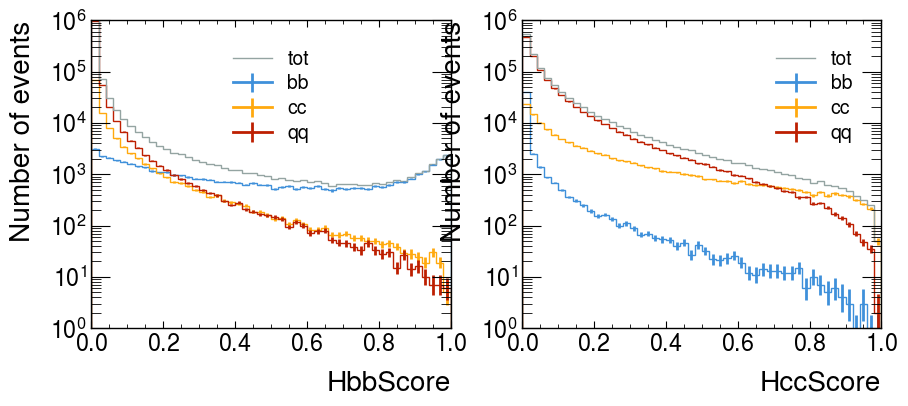

In [ ]:
name1 = 'fatJetGN2XHbb'
name2 = 'fatJetGN2XHcc'
generate_plot_with_hist(data, name1, name2)

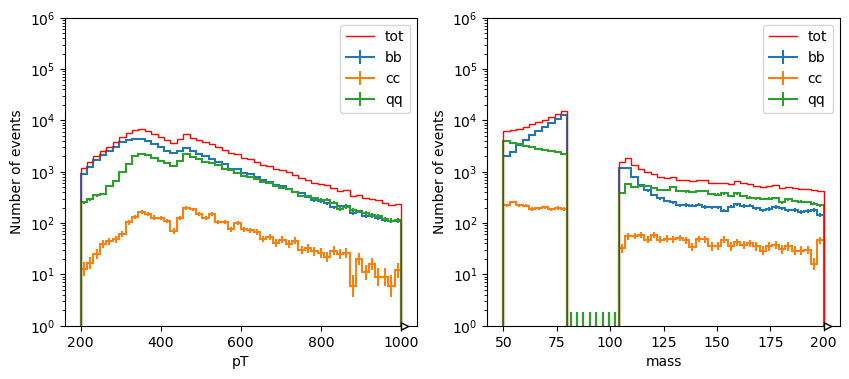

In [ ]:
name1 = 'pT'
name2 = 'mass'
generate_plot_with_hist(precut, name1, name2)

### Generate a HbbScore vs HccScore (purity/efficiency/uncertainty) heat map
First of all, need to 

In [1115]:
def initialize_N(strategy_number, sample_type, weighted_or_not):
    if strategy_number == 1:
        bb_score = 0. # HbbScore>0 is not adding any cut
    if strategy_number == 2:
        bb_score = 1. # HbbScore<1 is not adding any cut
    cc_score = 0. # HccScore>0. is equivalent to not adding any cut
    file_path = f'../../{sample_type}_{weighted_or_not}_kinematics_distribution/Hbb_Hcc_cuts/strategy_{strategy_number}/HbbScore{sign[strategy_number-1]}%.2f_HccScore>%.2f.p'%(bb_score, cc_score)
    with open(file_path, 'rb') as fp:
        data = pickle.load(fp)
    N_bb_cc_qq = np.sum(data['fatJetGN2XHbb'].to_numpy()[0], axis=-1) # Number of bb, cc, qq jets without any cut
    Ntot = np.sum(N_bb_cc_qq)
    Nbb = N_bb_cc_qq[0]
    Ncc = N_bb_cc_qq[1]
    Nqq = N_bb_cc_qq[2]
    return Ntot, Ncc, Nbb, Nqq

In [1084]:
strategy_number=1
sample_type='bkg'
bb_score=0.
cc_score=.1
file_path = f'../../{sample_type}_{weighted_or_not}_kinematics_distribution/Hbb_Hcc_cuts/strategy_{strategy_number}/HbbScore{sign[strategy_number-1]}%.2f_HccScore>%.2f.p'%(bb_score, cc_score)
with open(file_path, 'rb') as fp:
    data = pickle.load(fp)

In [ ]:
data.keys()

dict_keys(['fatJetM', 'fatJetpT', 'fatJetGN2XHbb', 'fatJetGN2XHcc', 'Hbb_Hcc_cut'])

In [214]:
strategy_number=1

# Compute the Ntot for each jet after applying different cuts
Diff_cut_N = [] # [[Nbb,Ncc,Nqq(with Hbb>A cut)], [Nbb,Ncc,Nqq(with Hcc>B cut)], [Nbb,Ncc,Nqq(with Hbb>A & Hcc>B cut)]]
count = 0
for hist_name, hist in data.items():
    if hist_name =='Hbb_Hcc_cut':
        continue
    print(hist_name, np.sum(data[hist_name].to_numpy()[0], axis=-1))
    if count%2 == 0:
        Diff_cut_N.append(np.sum(data[hist_name].to_numpy()[0], axis=-1))
    count += 1
Diff_cut_N
'''
######## Conclusion #########
- With the same cut, # of different jets should be the same for both GN2XHbb and GN2XHcc
'''

## setup the variables before applying any Hbb/Hcc cut (Note pt_m cut has been applied)
Ntot_before_cut, Ncc_before_cut, Nbb_before_cut, Nqq_before_cut = initialize_N(strategy_number, sample_type)

fatJetM [  2296.  41663. 163487.]
fatJetpT [  3093.  54242. 196480.]
fatJetGN2XHbb [  3096.  54275. 196506.]
fatJetGN2XHcc [  3096.  54275. 196506.]


In [ ]:
import numpy as np

a = np.array([1, 2, 0, 4])

# Check if the array contains zero
has_zero = np.isin(0, a)
has_zero = np.any(a == 0)
has_zero

True

In [ ]:
data.keys()

dict_keys(['fatJetM', 'fatJetpT', 'fatJetGN2XHbb', 'fatJetGN2XHcc', 'Hbb_Hcc_cut'])

In [182]:
for name in data.keys():
    if name == 'Hbb_Hcc_cut':
        continue
    N_flavor = data[name].to_numpy()[0] # N_flavor containts fatJetGN2XHbb distribution for each flavor
    Ntot_after_cut = np.sum(N_flavor)
    Nbb_after_cut, Ncc_after_cut, Nqq_after_cut= np.sum(N_flavor, axis=-1)
    
    if Ntot_after_cut != 0:
        Ntot_bin_after_cut = np.sum(N_flavor, axis=0) # total number of events in each bin
        N_bins = len(Ntot_bin_after_cut)
        has_zero = np.any(Ntot_bin_after_cut == 0)
        if has_zero == True:        
            print('has zero')
            index = np.where(Ntot_bin_after_cut==0)[0][0]
            sigma2_bins = N_flavor[:, :index]/(Ntot_bin_after_cut[:index])**3*(np.tile(Ntot_bin_after_cut[:index], (len(N_flavor), 1))+N_flavor[:, :index])
        else:
            # sigma square for each bin (three flavors)
            sigma2_bins = N_flavor/(Ntot_bin_after_cut)**3*(np.tile(Ntot_bin_after_cut, (len(N_flavor), 1))+N_flavor)
        frac_bb_sigma, frac_cc_sigma, frac_qq_sigma =  np.sqrt(np.sum(sigma2_bins, axis=-1)/N_bins)
    else:
        frac_bb_sigma, frac_cc_sigma, frac_qq_sigma = np.zeros(3)
    print(f'fraction uncertainties for bb, cc, qq of {name}', frac_bb_sigma, frac_cc_sigma, frac_qq_sigma)

fraction uncertainties for bb, cc, qq of fatJetM 0.028258287548673384 0.010701971384084212 0.039553863427754764
fraction uncertainties for bb, cc, qq of fatJetpT 0.03707930302493195 0.007913671912934041 0.028509482063586482
fraction uncertainties for bb, cc, qq of fatJetGN2XHbb 0.06623847996976137 0.007331672488594673 0.012119305655989671
fraction uncertainties for bb, cc, qq of fatJetGN2XHcc 0.14659857319000208 0.22768828881866268 0.07774805442587035
fraction uncertainties for bb, cc, qq of fatJetGN2XTop 0.034726243748195273 0.01097669668103208 0.03509107803360208
fraction uncertainties for bb, cc, qq of fatJetGN2XQCD 0.021867350788420066 0.011356606954268706 0.04323145793069539


In [842]:
N_flavor = data['fatJetGN2XHbb'].to_numpy()[0] # N_flavor containts fatJetGN2XHbb distribution for each flavor
Ntot_after_cut = np.sum(N_flavor)
Nbb_after_cut, Ncc_after_cut, Nqq_after_cut= np.sum(N_flavor, axis=-1)
print(Nbb_after_cut, Ncc_after_cut, Nqq_after_cut)
bb_efficiency = Nbb_after_cut/Nbb_before_cut
qq_efficiency = Nqq_after_cut/Nqq_before_cut
print(np.sqrt((Ntot_after_cut*(Ntot_before_cut+Ntot_after_cut)\
                                +bb_efficiency*Nbb_before_cut*(Ntot_before_cut+bb_efficiency*Nbb_before_cut)\
                                +qq_efficiency*Nqq_before_cut*(Ntot_before_cut+qq_efficiency*Nqq_before_cut))/Ntot_before_cut**3))
print(np.sqrt((Ntot_after_cut*(Ntot_before_cut+Ntot_after_cut)\
                                +bb_efficiency**2*Nbb_before_cut*(Ntot_before_cut+Nbb_before_cut)\
                                +qq_efficiency**2*Nqq_before_cut*(Ntot_before_cut+Nqq_before_cut))/Ntot_before_cut**3))
#np.sqrt(Ntot_after_cut+bb_efficiency**2*Nbb_before_cut+qq_efficiency**2*Nqq_before_cut)/Ntot_before_cut
print(np.sqrt(Ncc_after_cut*(Ntot_before_cut+Ncc_after_cut)/Ntot_before_cut**3))

3096.0 54275.0 196506.0
0.0005778697144649281
0.00048098942236404025
0.00018797613138730454


In [1133]:
def calculate_efficiency_purity(data, Ntot_before_cut, Nbb_before_cut, Ncc_before_cut, Nqq_before_cut):
    #data['fatJetGN2XHbb'].to_numpy() contains three arrays, the first one is the # of events for each flavor, the last one is the histogram edges
    N_flavor = data['fatJetGN2XHbb'].to_numpy()[0] # N_flavor containts fatJetGN2XHbb distribution for each flavor
    Ntot_after_cut = np.sum(N_flavor)
    Nbb_after_cut, Ncc_after_cut, Nqq_after_cut= np.sum(N_flavor, axis=-1)
    
    if Ntot_after_cut == 0:
        frac_cc_after_cut = frac_bb_after_cut = frac_qq_after_cut = frac_bb_sigma=frac_cc_sigma=frac_qq_sigma = 0.00
        cc_efficiency=bb_efficiency=qq_efficiency=tot_efficiency = 1.
        b=1
    else:
        '''
        frac_cc_after_cut = Ncc_after_cut/Ntot_after_cut
        frac_bb_after_cut = Nbb_after_cut/Ntot_after_cut
        frac_qq_after_cut = Nqq_after_cut/Ntot_after_cut #'''
        
        frac_cc_after_cut = Ncc_after_cut/Ntot_after_cut
        frac_bb_after_cut = Nbb_after_cut/Ntot_before_cut
        frac_qq_after_cut = Nqq_after_cut/Ntot_before_cut
        cc_efficiency = Ncc_after_cut/Ncc_before_cut
        bb_efficiency = Nbb_after_cut/Nbb_before_cut
        qq_efficiency = Nqq_after_cut/Nqq_before_cut
        tot_efficiency = Ntot_after_cut/Ntot_before_cut
        
        '''
        frac_cc_sigma = 2*np.sqrt(Ncc_after_cut)/Ntot_after_cut
        frac_bb_sigma = 2*np.sqrt(Nbb_after_cut)/Ntot_after_cut
        frac_qq_sigma = 2*np.sqrt(Nqq_after_cut)/Ntot_after_cut #'''
        
        #frac_cc_sigma = np.sqrt((Ntot_after_cut*(Ntot_before_cut+Ntot_after_cut)\
        #                        +bb_efficiency*Nbb_before_cut*(Ntot_before_cut+bb_efficiency*Nbb_before_cut)\
        #                        +qq_efficiency*Nqq_before_cut*(Ntot_before_cut+qq_efficiency*Nqq_before_cut))/Ntot_before_cut**3)
        #frac_cc_sigma = np.sqrt((Ntot_after_cut*(Ntot_before_cut+Ntot_after_cut)\
        #                        +bb_efficiency**2*Nbb_before_cut*(Ntot_before_cut+Nbb_before_cut)\
        #                        +qq_efficiency**2*Nqq_before_cut*(Ntot_before_cut+Nqq_before_cut))/Ntot_before_cut**3)
        #frac_cc_sigma = np.sqrt(Ntot_after_cut+bb_efficiency**2*Nbb_before_cut+qq_efficiency**2*Nqq_before_cut)/Ntot_before_cut
        
        frac_cc_sigma = np.sqrt((Ntot_after_cut-Ncc_after_cut)/(Ntot_after_cut**2)/frac_cc_after_cut)
        frac_bb_sigma = np.sqrt(Nbb_after_cut)/bb_efficiency
        frac_qq_sigma = np.sqrt(Nqq_after_cut)/qq_efficiency 
        
        '''
        #############Calculate Nbb + Ntot#############
        np.tile(Ntot_bin_after_cut, (len(N_flavor), 1))+N_flavor #N_flavor + Ntot
        #############Calculate Nbb/Ntot#############        
        
        Ntot_bin_after_cut = np.sum(N_flavor, axis=0) # total number of events in each bin
        N_bins = len(Ntot_bin_after_cut)
        has_zero = np.any(Ntot_bin_after_cut == 0)
        if has_zero == True:        
            index = np.where(Ntot_bin_after_cut==0)[0][0]
            sigma2_bins = N_flavor[:, :index]/(Ntot_bin_after_cut[:index])**3*(np.tile(Ntot_bin_after_cut[:index], (len(N_flavor), 1))+N_flavor[:, :index])
        else:
            # sigma square for each bin (three flavors)
            sigma2_bins = N_flavor/(Ntot_bin_after_cut)**3*(np.tile(Ntot_bin_after_cut, (len(N_flavor), 1))+N_flavor)
        frac_bb_sigma, frac_cc_sigma, frac_qq_sigma =  np.sqrt(np.sum(sigma2_bins, axis=-1)/N_bins)#'''
        b=0

    
    cuts = data['Hbb_Hcc_cut']
    basket = np.array([frac_cc_after_cut, frac_bb_after_cut, frac_qq_after_cut, frac_cc_sigma, frac_bb_sigma, frac_qq_sigma, cc_efficiency, bb_efficiency, qq_efficiency, tot_efficiency, b])    
        
    return basket, cuts

In [1099]:
calculate_efficiency_purity(data, Ntot_before_cut, Nbb_before_cut, Ncc_before_cut, Nqq_before_cut)

(array([0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 1.    , 1.    ,
        1.    , 1.    , 1.    ]),
 'HbbScore>1.00_HccScore>1.00')

In [1134]:
strategy_number=1
Ntot_before_cut, Ncc_before_cut, Nbb_before_cut, Nqq_before_cut = initialize_N(strategy_number, sample_type, weighted_or_not)
# Trying to find the cuts that can give us the minimal uncertainty
bb_scores = np.linspace(0,1,11)
cc_scores = np.linspace(0,1,11)
dim_bb = len(bb_scores[:])
dim_cc = len(cc_scores[:])
baskets=[]
cuts=[]

for bb_score in bb_scores[:]:
    for cc_score in cc_scores[:]:
        file_path = f'../../{sample_type}_{weighted_or_not}_kinematics_distribution/Hbb_Hcc_cuts/strategy_{strategy_number}/HbbScore{sign[strategy_number-1]}%.2f_HccScore>%.2f.p'%(bb_score, cc_score)
        with open(file_path, 'rb') as fp:
            data = pickle.load(fp)
            basket, cut = calculate_efficiency_purity(data, Ntot_before_cut, Nbb_before_cut, Ncc_before_cut, Nqq_before_cut)
            if cut == f'HbbScore{sign[strategy_number-1]}%.2f_HccScore>%.2f'%(0., 0.):
                print(basket[9])
            baskets.append(basket)
            cuts.append(cut)#'''
frac_cc_after_cut = np.array(baskets)[:,0]
frac_bb_after_cut = np.array(baskets)[:,1]
frac_qq_after_cut = np.array(baskets)[:,2]
frac_cc_sigma = np.array(baskets)[:,3]
frac_bb_sigma = np.array(baskets)[:,4]
frac_qq_sigma = np.array(baskets)[:,5]
cc_efficiency = np.array(baskets)[:,6]
bb_efficiency = np.array(baskets)[:,7]
qq_efficiency = np.array(baskets)[:,8]
tot_efficiency = np.array(baskets)[:,9]
non_zero = np.array(baskets)[:,10]

1.0


(array([93., 12.,  4.,  5.,  0.,  2.,  1.,  1.,  1.,  2.]),
 array([  0.        ,  24.85475065,  49.70950129,  74.56425194,
         99.41900259, 124.27375324, 149.12850388, 173.98325453,
        198.83800518, 223.69275583, 248.54750647]),
 <BarContainer object of 10 artists>)

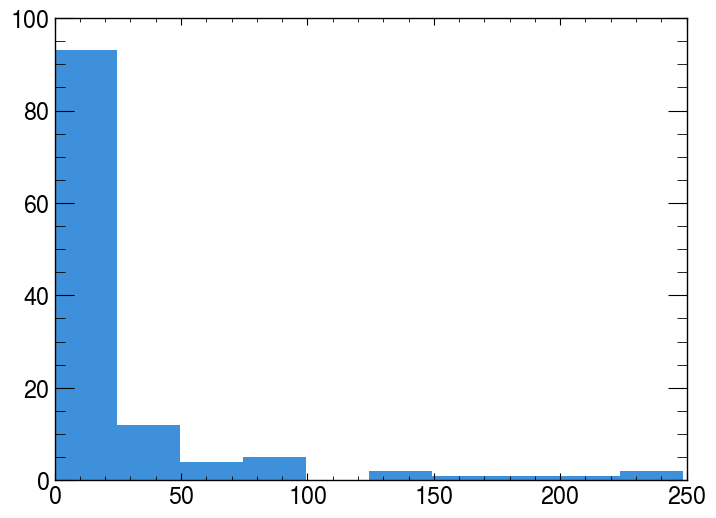

In [1109]:
plt.hist(frac_cc_sigma)

In [1079]:
def make_2d_heat_map(var, name, strategy_number):
    HbbScores = np.array([float(cuts[i][9:13]) for i in range(len(cuts))])
    HccScores = np.array([float(cuts[i][23:27]) for i in range(len(cuts))])

    Hbb_score_xticks_label = [f'{sign[strategy_number-1]}'+np.array2string(i) for i in HbbScores.reshape(dim_bb,dim_cc)[:, 0]]



    # Efficiency plots
    '''
    img = ax.imshow(var, extent=[0,1,0,1], cmap='viridis', aspect='auto')
    # Adding color bar
    fig.colorbar(img)#'''


    fig, ax = plt.subplots(1,1, figsize=(12,8))
    ax.matshow(var, cmap='Greens')

    for (i, j), z in np.ndenumerate(var):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
    ax.set_xticks(np.linspace(0, 10, dim_cc), labels=['>'+np.array2string(i) for i in HccScores.reshape(dim_bb,dim_cc)[0]])
    ax.set_yticks(np.linspace(0, 10, dim_bb), labels=Hbb_score_xticks_label)
    #for t in ax.get_xticklabels():
    #    t.set_va('bottom')
    ax.set_xlabel('Hcc Scores')
    ax.set_ylabel('Hbb Scores')
    ax.set_title(name)

In [1094]:
var

array([[ 65.48837423,  94.66277381, 105.11605687, 110.81883865,
        113.91818016, 115.05202551, 114.30950614, 111.37746008,
        104.13147738,  89.65213001,   0.17      ],
       [ 95.41657256, 113.85038668, 114.78823653, 115.10727549,
        114.64319018, 113.62368723, 110.88028882, 107.93572558,
         94.86263265,   0.17      ,   0.17      ],
       [ 85.70396204, 114.72973935, 115.10875129, 114.64801278,
        113.16948496, 111.59395634, 105.72979998, 105.05735712,
          0.17      ,   0.17      ,   0.17      ],
       [ 75.87895581, 114.79282292, 115.09564715, 114.13420993,
        111.01387113, 105.69415629,  72.71801508,   0.17      ,
          0.17      ,   0.17      ,   0.17      ],
       [ 66.573798  , 114.8618147 , 114.91766008, 112.815406  ,
        108.16016709, 114.10020772,   0.17      ,   0.17      ,
          0.17      ,   0.17      ,   0.17      ],
       [ 58.30728792, 114.50467853, 115.10010905, 114.23883265,
        101.04620737,   0.17      ,   0.1

"\nflavor_taggings = ['cc', 'bb', 'qq']\n\nfor count in range(len(baskets)):\n    if count < 3:\n        var = np.array(baskets)[:,count].reshape(dim_bb,dim_cc) *100\n        name = f'purity {flavor_taggings[count%3]} (%)'\n        make_2d_heat_map(var, name, strategy_number)\n    if (count > 2) & (count < 6):\n        var = np.array(baskets)[:,count].reshape(dim_bb,dim_cc) *100\n        name = f'fraction {flavor_taggings[count%3]} uncertainty (%)'\n        make_2d_heat_map(var, name, strategy_number)\n    if (count > 5) & (count < 9):\n        var = np.array(baskets)[:,count].reshape(dim_bb,dim_cc) *100\n        name = f'{flavor_taggings[count%3]} efficiency (%)'\n        make_2d_heat_map(var, name, strategy_number)\n    if count == 9:\n        var = np.array(baskets)[:,count].reshape(dim_bb,dim_cc) *100\n        name = f'total efficiency (%)'\n        make_2d_heat_map(var, name, strategy_number)\n    if count == 10:\n        var = np.array(baskets)[:,count].reshape(dim_bb,dim_cc)\n  

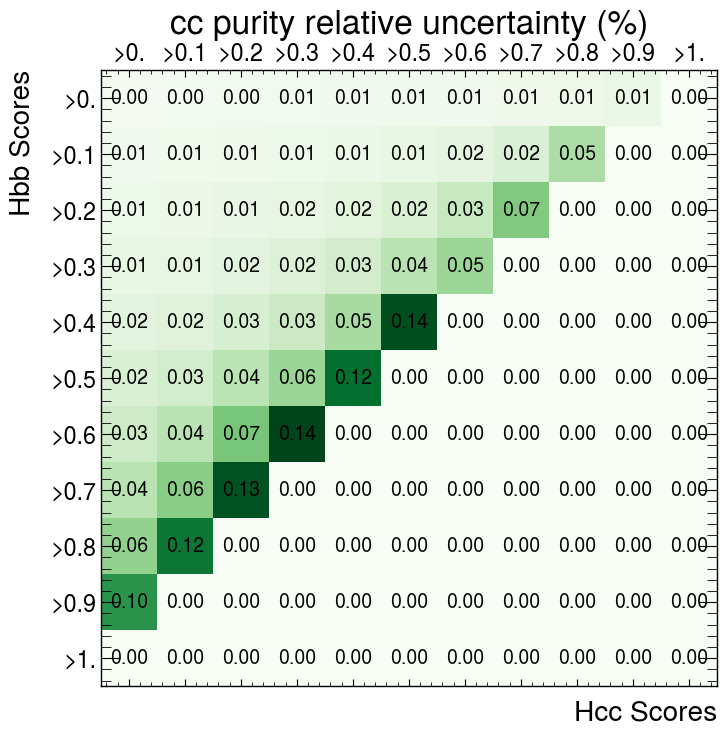

In [1136]:
#var = frac_cc_after_cut.reshape(dim_bb,dim_cc) *100
#name = 'purity cc (%)'
var = frac_cc_sigma.reshape(dim_bb,dim_cc) * 1
name = 'cc purity relative uncertainty (%)'
#var = bb_efficiency.reshape(dim_bb,dim_cc)*100
#name = 'bb efficiency (%)'
#var = non_zero.reshape(dim_bb,dim_cc)
#name = 'Ntot after cut==0?'

make_2d_heat_map(var, name, strategy_number)
'''
flavor_taggings = ['cc', 'bb', 'qq']

for count in range(len(baskets)):
    if count < 3:
        var = np.array(baskets)[:,count].reshape(dim_bb,dim_cc) *100
        name = f'purity {flavor_taggings[count%3]} (%)'
        make_2d_heat_map(var, name, strategy_number)
    if (count > 2) & (count < 6):
        var = np.array(baskets)[:,count].reshape(dim_bb,dim_cc) *100
        name = f'fraction {flavor_taggings[count%3]} uncertainty (%)'
        make_2d_heat_map(var, name, strategy_number)
    if (count > 5) & (count < 9):
        var = np.array(baskets)[:,count].reshape(dim_bb,dim_cc) *100
        name = f'{flavor_taggings[count%3]} efficiency (%)'
        make_2d_heat_map(var, name, strategy_number)
    if count == 9:
        var = np.array(baskets)[:,count].reshape(dim_bb,dim_cc) *100
        name = f'total efficiency (%)'
        make_2d_heat_map(var, name, strategy_number)
    if count == 10:
        var = np.array(baskets)[:,count].reshape(dim_bb,dim_cc)
        name = 'Ntot after cut==0?'
        make_2d_heat_map(var, name, strategy_number)#'''

#ax.axis('off')


#plt.savefig('../slides_plots/cc_purity_bothcut_2D.png', dpi=200)

In [ ]:
var

array([[ 0.24527069,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.28692825,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 3.31700318,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 2.77358554,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 5.2951834 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 8.93234101,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.   

## Make animation

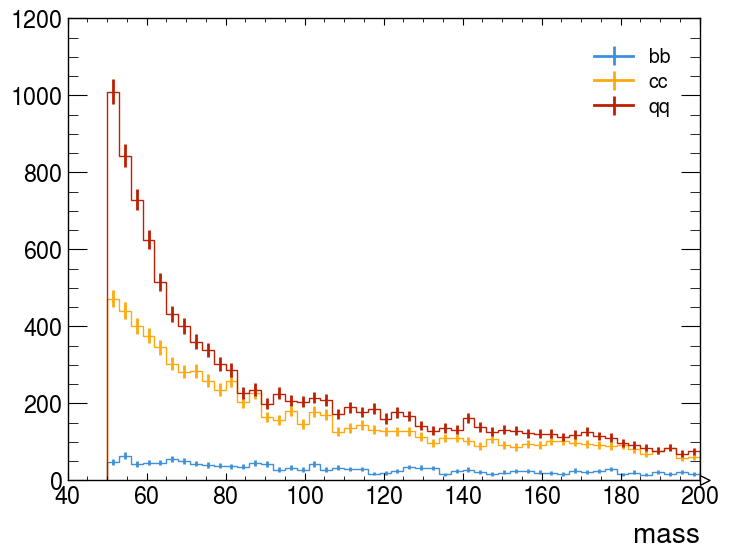

In [1514]:
plt.legend()

In [ ]:
strategy_number = 1
bb_score = 0.0
cc_score = 0.1
file_path = f'../../{sample_type}_{weight_or_not}_kinematics_distribution/Hbb_Hcc_cuts/strategy_{strategy_number}/HbbScore{sign[strategy_number-1]}%.2f_HccScore>%.2f.p'%(bb_score, cc_score)
with open(file_path, 'rb') as fp:
    data = pickle.load(fp)


In [1550]:
%pip install --upgrade matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 47.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.4
    Uninstalling matplotlib-3.8.4:
      Successfully uninstalled matplotlib-3.8.4
Note: you may need to restart the kernel to use updated packages.


In [1555]:
np.arange(0,1.1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [1556]:
frame_datas = np.array([(i,j) for i in np.arange(0,1.1,0.1) for j in np.arange(0,1.1,0.1)])

In [ ]:
fig, ax = plt.subplots()
from matplotlib.animation import FuncAnimation
strategy_number = 1

def update(frame_data):
    bb_score, cc_score = frame_data
    file_path = f'../../{sample_type}_{weight_or_not}_kinematics_distribution/Hbb_Hcc_cuts/strategy_{strategy_number}/HbbScore{sign[strategy_number-1]}%.2f_HccScore>%.2f.p'%(bb_score, cc_score)
    with open(file_path, 'rb') as fp:
        data = pickle.load(fp)
        
    ax.cla()  # Clear the previous plot
    data['fatJetM'].plot1d()
    ax.legend()
    ax.set_title(f"HbbScore>%.2f, HccScore>%.2f"%(bb_score, cc_score))
    #ax.set_yscale('log')

# Create the animation
ani = FuncAnimation(fig, update, frames=frame_datas, interval=500, repeat=True)
ani.save("../../histogram_animation.gif", writer="imagemagick", dpi=300)

plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.
/usr/local/lib/python3.10/site-packages/mplhep/utils.py:199: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.10/site-packages/mplhep/utils.py:199: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.10/site-packages/mplhep/utils.py:199: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/tmp/ipykernel_203/2832343484.py:15: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
/usr/local/lib/python3.10/site-packages/mplhep/utils.py:199: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/us